Imports

In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import lime
import lime.lime_tabular

import missingno as msno
from scipy.stats import f_oneway, chi2_contingency

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler

from sklearn.model_selection import train_test_split, cross_validate, learning_curve, validation_curve, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error, make_scorer, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

import joblib
import pickle

from fonctions import *
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

1. Data Exploration / Data Cleaning


Explication des données

* id : identifiant unique.  
* gender : genre du patient.  
* age : âge du patient.  
* hypertension : 0 si le patient n'a pas d'hypertension, 1 si le patient a de
l'hypertension.
* heart_disease : 0 si le patient n'a pas de maladie cardiaque, 1 si le
patient a une maladie cardiaque.
* ever_married : si le patient a déjà été marié ou pas.
* work_type : type de travail du patient.
* Residence_type : type de résidence du patient "Rural" ou "Urbain" (=1).
* avg_glucose_level : taux moyen de glucose dans le sang.
* bmi : indice de masse corporelle.
* smoking_status : "a déjà fumé", "n'a jamais fumé", "fumé" ou "Inconnu ".
* stroke : 1 si le patient a eu un accident vasculaire cérébral ou 0 s'il n'en
a pas eu.

In [3]:
df.head(3)

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   

   stroke  
0       1  
1       1  
2       1

In [4]:
df.describe(include='all')

id  gender          age  hypertension  heart_disease  \
count    5110.000000    5110  5110.000000   5110.000000    5110.000000   
unique           NaN       3          NaN           NaN            NaN   
top              NaN  Female          NaN           NaN            NaN   
freq             NaN    2994          NaN           NaN            NaN   
mean    36517.829354     NaN    43.226614      0.097456       0.054012   
std     21161.721625     NaN    22.612647      0.296607       0.226063   
min        67.000000     NaN     0.080000      0.000000       0.000000   
25%     17741.250000     NaN    25.000000      0.000000       0.000000   
50%     36932.000000     NaN    45.000000      0.000000       0.000000   
75%     54682.000000     NaN    61.000000      0.000000       0.000000   
max     72940.000000     NaN    82.000000      1.000000       1.000000   

       ever_married work_type Residence_type  avg_glucose_level          bmi  \
count          5110      5110           5110        5110.000000  4909.000000   
unique            2         5              2                NaN          NaN   
top             Yes   Private          Urban                NaN          NaN   
freq           3353      2925           2596                NaN          NaN   
mean            NaN       NaN            NaN         106.147677    28.893237   
std             NaN       NaN            NaN          45.283560     7.854067   
min             NaN       NaN            NaN          55.120000    10.300000   
25%             NaN       NaN            NaN          77.245000    23.500000   
50%             NaN       NaN            NaN          91.885000    28.100000   
75%             NaN       NaN            NaN         114.090000    33.100000   
max             NaN       NaN            NaN         271.740000    97.600000   

       smoking_status       stroke  
count            5110  5110.000000  
unique              4          NaN  
top      never smoked          NaN  
freq             1892          NaN  
mean              NaN     0.048728  
std               NaN     0.215320  
min               NaN     0.000000  
25%               NaN     0.000000  
50%               NaN     0.000000  
75%               NaN     0.000000  
max               NaN     1.000000

**Premières observations :** 
* L'échantillon comprend des individus dont l'âge est compris entre 8 mois et 82 ans (moyenne = 43 ans).  
* la colonne bmi contient des outliers qu'il va falloir traiter ainsi que des valeurs manquantes.  
* La colonne smoking_status contient également des valeurs manquantes.
* La colonne avg_glucose_level semble contenir des données pertinentes et sans outliers.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
df.stroke.value_counts(normalize=True)

stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64

On vérifie s'il y'a des doublons et des valeurs manquantes

In [7]:
df.duplicated().sum()

0

In [8]:
for col in df.select_dtypes('number'):
    print("_____",col)
    print("nbr_nan:",df[col].isna().sum())
    print("valeurs uniques :",df[col].nunique())
    print(df[col].unique()[:5])
    print("_ _ _ _ _ _ _ _ _ _")
    print("_ _ _ _ _ _ _ _ _ _")

_____ id
nbr_nan: 0
valeurs uniques : 5110
[ 9046 51676 31112 60182  1665]
_ _ _ _ _ _ _ _ _ _
_ _ _ _ _ _ _ _ _ _
_____ age
nbr_nan: 0
valeurs uniques : 104
[67. 61. 80. 49. 79.]
_ _ _ _ _ _ _ _ _ _
_ _ _ _ _ _ _ _ _ _
_____ hypertension
nbr_nan: 0
valeurs uniques : 2
[0 1]
_ _ _ _ _ _ _ _ _ _
_ _ _ _ _ _ _ _ _ _
_____ heart_disease
nbr_nan: 0
valeurs uniques : 2
[1 0]
_ _ _ _ _ _ _ _ _ _
_ _ _ _ _ _ _ _ _ _
_____ avg_glucose_level
nbr_nan: 0
valeurs uniques : 3979
[228.69 202.21 105.92 171.23 174.12]
_ _ _ _ _ _ _ _ _ _
_ _ _ _ _ _ _ _ _ _
_____ bmi
nbr_nan: 201
valeurs uniques : 418
[36.6  nan 32.5 34.4 24. ]
_ _ _ _ _ _ _ _ _ _
_ _ _ _ _ _ _ _ _ _
_____ stroke
nbr_nan: 0
valeurs uniques : 2
[1 0]
_ _ _ _ _ _ _ _ _ _
_ _ _ _ _ _ _ _ _ _


In [9]:
df = df.loc[(df['bmi']>10)|(df['bmi'].isna()),:]
df = df.loc[(df['bmi']<50)|(df['bmi'].isna()),:]

Après vérification, il apparaît que la colonne bmi contient des valeurs abbérantes car il n'est pas possible d'avoir un IMC inférieur à 10.3 ou supérieur à 97.60.  

In [10]:
for col in df.select_dtypes('object'):
    print("_____",col)
    print("nbr_nan:",df[col].isna().sum())
    print("valeurs uniques :",df[col].nunique())
    print(df[col].unique()[:5])
    print(df[col].value_counts())
    print("_ _ _ _ _ _ _ _ _ _")
    print("_ _ _ _ _ _ _ _ _ _")

_____ gender
nbr_nan: 0
valeurs uniques : 3
['Male' 'Female' 'Other']
gender
Female    2935
Male      2095
Other        1
Name: count, dtype: int64
_ _ _ _ _ _ _ _ _ _
_ _ _ _ _ _ _ _ _ _
_____ ever_married
nbr_nan: 0
valeurs uniques : 2
['Yes' 'No']
ever_married
Yes    3289
No     1742
Name: count, dtype: int64
_ _ _ _ _ _ _ _ _ _
_ _ _ _ _ _ _ _ _ _
_____ work_type
nbr_nan: 0
valeurs uniques : 5
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
work_type
Private          2867
Self-employed     809
children          687
Govt_job          646
Never_worked       22
Name: count, dtype: int64
_ _ _ _ _ _ _ _ _ _
_ _ _ _ _ _ _ _ _ _
_____ Residence_type
nbr_nan: 0
valeurs uniques : 2
['Urban' 'Rural']
Residence_type
Urban    2560
Rural    2471
Name: count, dtype: int64
_ _ _ _ _ _ _ _ _ _
_ _ _ _ _ _ _ _ _ _
_____ smoking_status
nbr_nan: 0
valeurs uniques : 4
['formerly smoked' 'never smoked' 'smokes' 'Unknown']
smoking_status
never smoked       1859
Unknown            1523


On retire la ligne dont le genre est 'other' car une seule valeur ne peut pas représenter une classe


In [11]:
df= df.loc[df['gender']!='Other',:]

<Axes: >

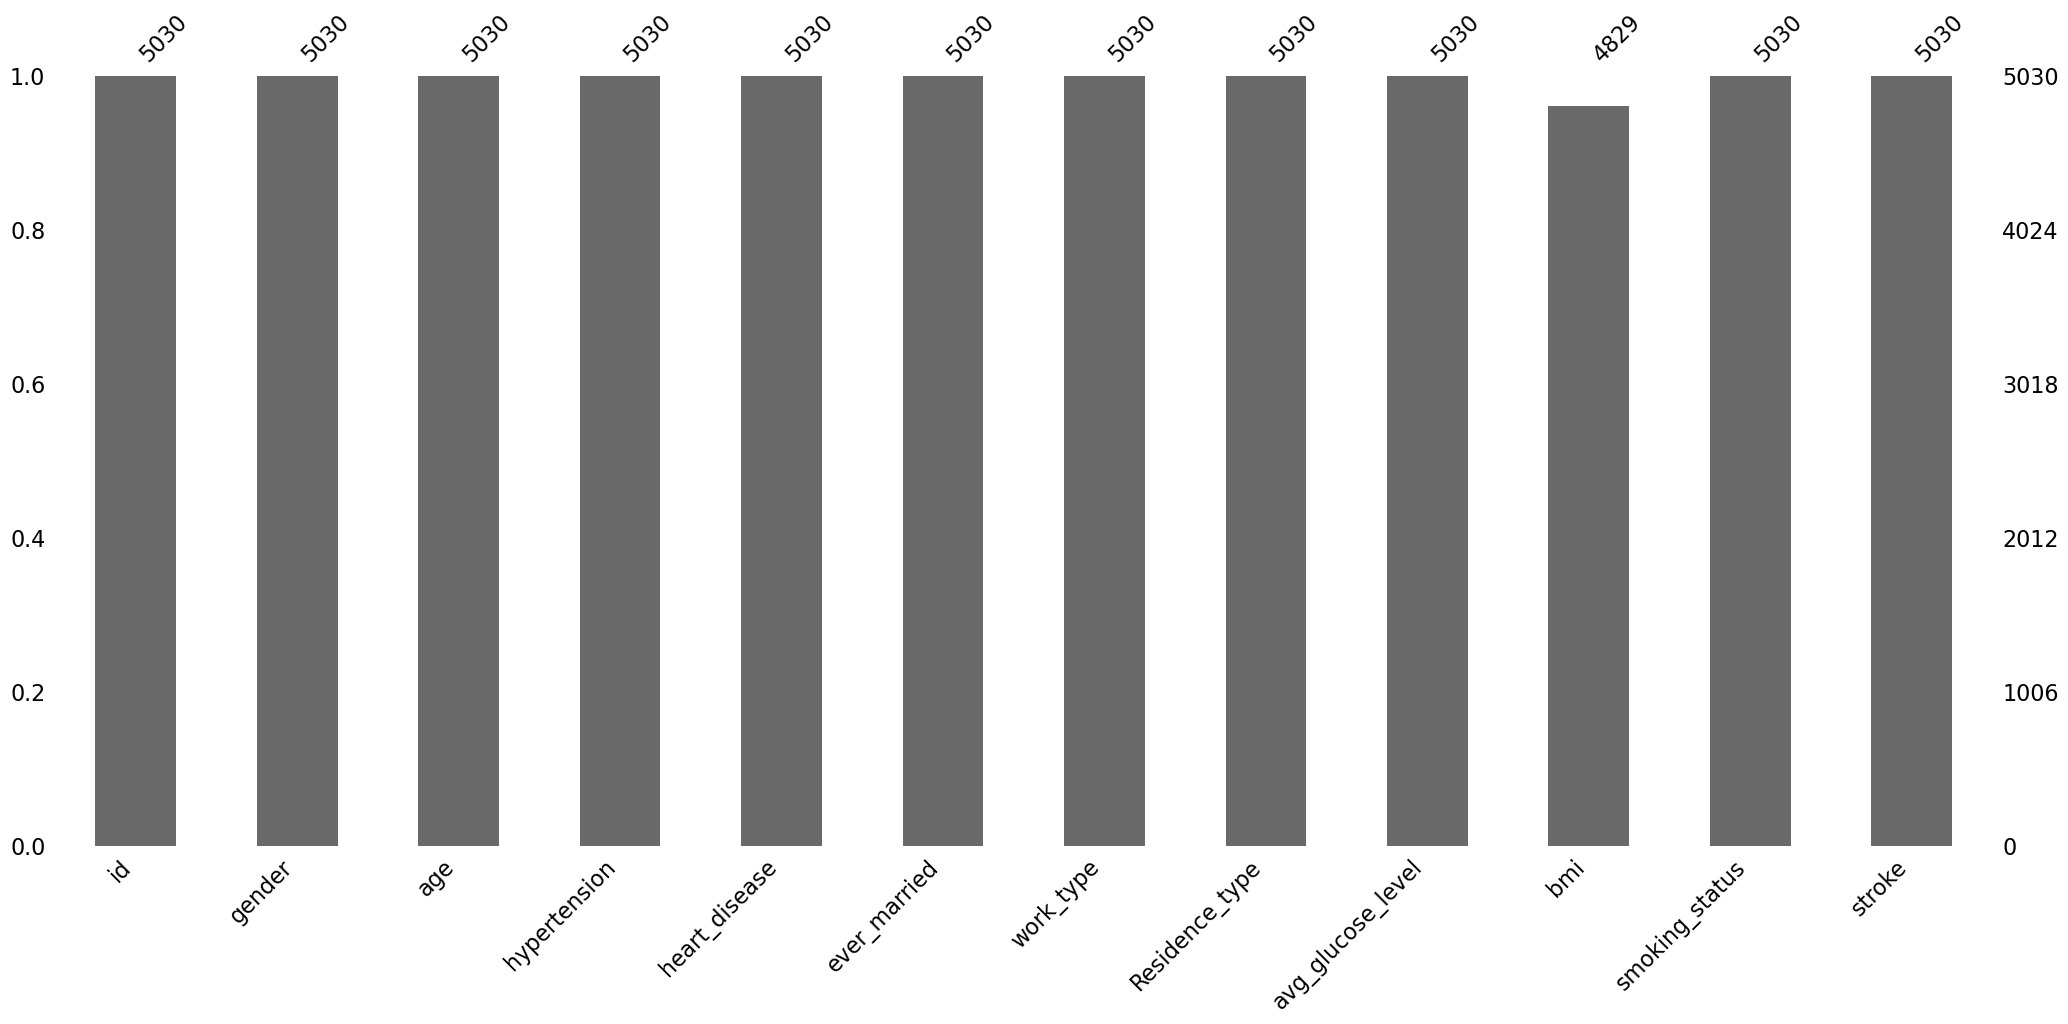

In [12]:
msno.bar(df)

In [13]:
df.loc[df['bmi'].isna()]['bmi'].shape

(201,)

La colonne **bmi** contient 201 valeurs manquantes.  
Avant de choisir une méthode d'imputation, nous décidons d'observer l'ensemble de mes variables. Cela nous permettra de déterminer la méthode optimale d'imputation.

In [14]:
df.smoking_status.value_counts(normalize=True)

smoking_status
never smoked       0.369583
Unknown            0.302783
formerly smoked    0.173161
smokes             0.154473
Name: proportion, dtype: float64

30% de valeur non renseignée/manquante dans la colonne smoking_status, nous procéderons à une imputation par la suite.

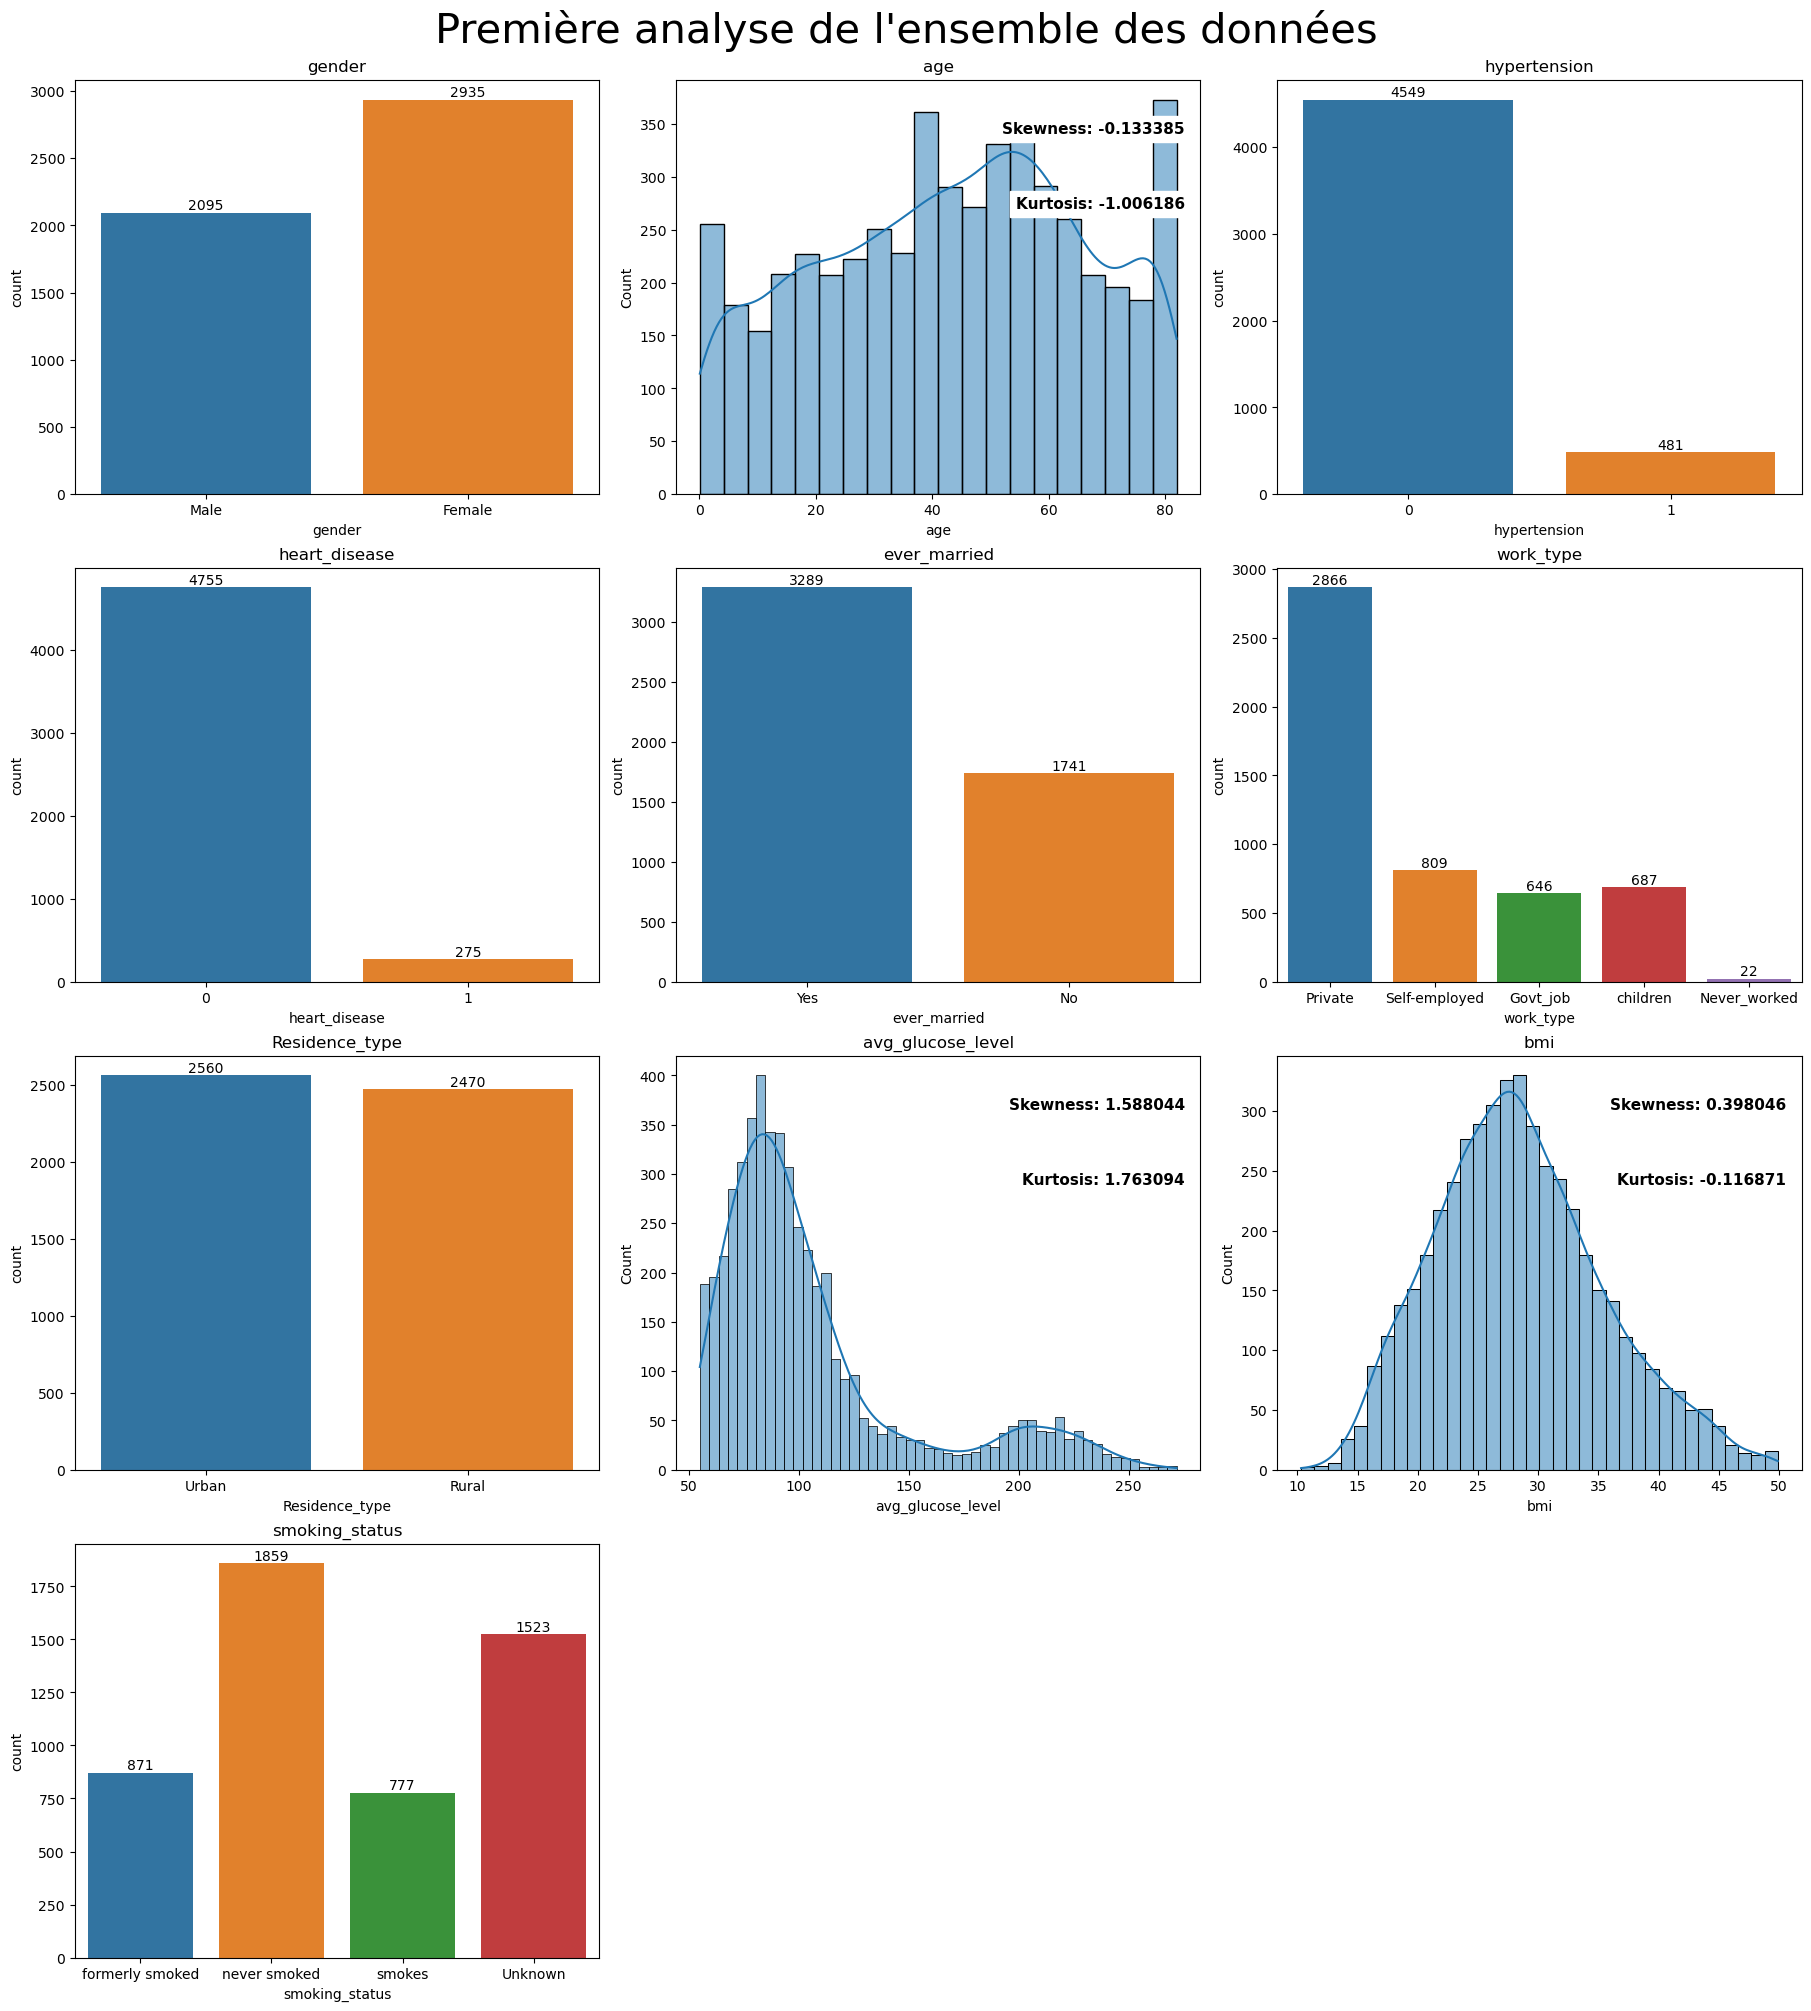

In [15]:
columns = df.columns[1:]

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 20), constrained_layout=True)
plt.suptitle("Première analyse de l'ensemble des données", fontsize=30)

for i, column in enumerate(columns):
    row = i // 3
    col = i % 3

    if df[column].dtype == 'object' or df[column].dtype=='int64':
        sns.countplot(x=column, data=df, ax=axes[row, col])
        axes[row, col].bar_label(axes[row, col].containers[0])
        axes[row, col].set_title(f'{column}')
    else:
        sns.histplot(x=column, data=df, kde=True, ax=axes[row, col])
        axes[row, col].set_title(f'{column}')

        skewness = df[column].skew()
        kurt = df[column].kurt()
        if not pd.isnull(skewness) and not pd.isnull(kurt):
            axes[row, col].text(x=0.97, y=0.90, transform=axes[row, col].transAxes,
                                s="Skewness: %f" % skewness,
                                fontweight='demibold', fontsize=11, verticalalignment='top',
                                horizontalalignment='right', backgroundcolor='white')
            axes[row, col].text(x=0.97, y=0.70, transform=axes[row, col].transAxes,
                                s="Kurtosis: %f" % kurt,
                                fontweight='demibold', fontsize=11, verticalalignment='center',
                                horizontalalignment='right', backgroundcolor='white')

fig.delaxes(axes[3,2])
fig.delaxes(axes[3,1])
plt.show()


Avant de commencer l'analyse des différentes variables, on remarque que la colonne stroke (dite target) est déséquilibrée.

On divise le dataframe afin d'isoler deux groupes stroke (0/1) et on relance les graphiques.

On va s'intéresser dans un premier temps aux patients qui n'ont jamais eu d'AVC

In [16]:
df_0= df.loc[df['stroke']==0,:]
df_1= df.loc[df['stroke']==1,:]

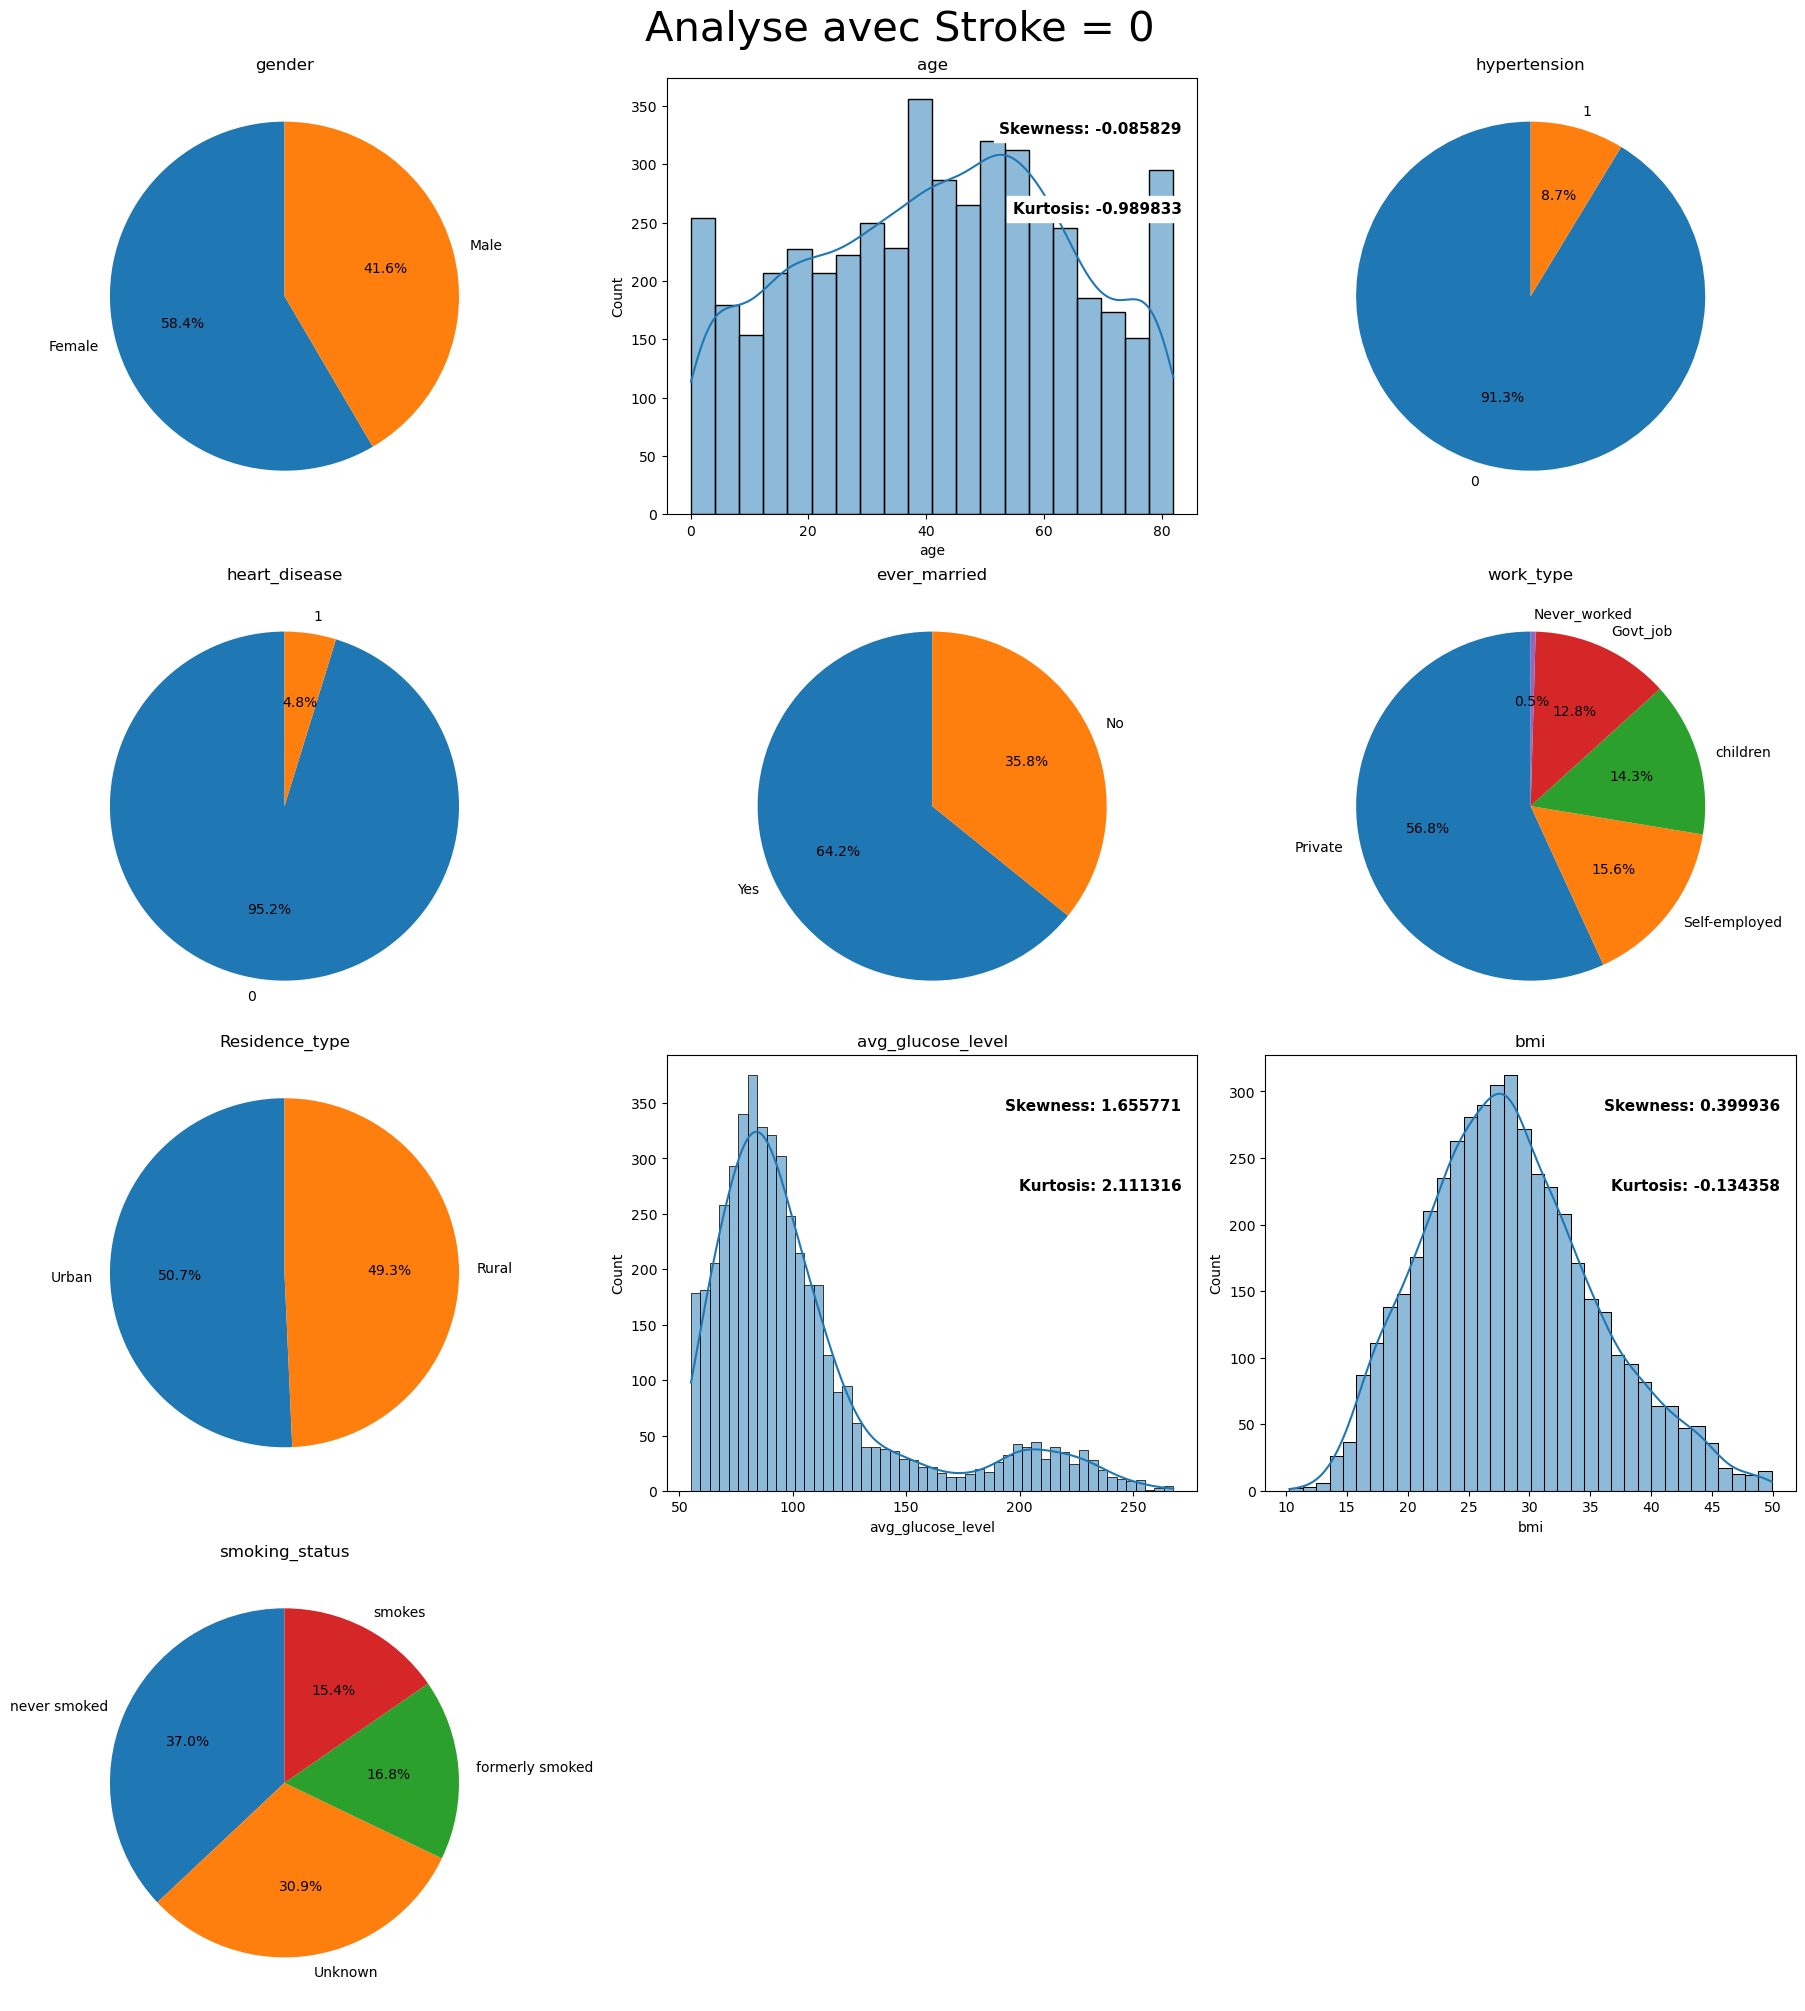

In [17]:
columns = df_0.columns[1:]

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 20), constrained_layout=True)
plt.suptitle("Analyse avec Stroke = 0", fontsize=30)

for i, column in enumerate(columns):
    row = i // 3
    col = i % 3

    if df_0[column].dtype == 'object' or df_0[column].dtype == 'int64':
        proportions = df_0[column].value_counts(normalize=True)
        axes[row, col].pie(proportions, labels=proportions.index, autopct='%1.1f%%', startangle=90)
        axes[row, col].set_title(f'{column}')
    else:
        sns.histplot(x=column, data=df_0, kde=True, ax=axes[row, col])
        axes[row, col].set_title(f'{column}')
        skewness = df_0[column].skew()
        kurt = df_0[column].kurt()
        if not pd.isnull(skewness) and not pd.isnull(kurt):
            axes[row, col].text(x=0.97, y=0.90, transform=axes[row, col].transAxes,
                                s="Skewness: %f" % skewness,
                                fontweight='demibold', fontsize=11, verticalalignment='top',
                                horizontalalignment='right', backgroundcolor='white')
            axes[row, col].text(x=0.97, y=0.70, transform=axes[row, col].transAxes,
                                s="Kurtosis: %f" % kurt,
                                fontweight='demibold', fontsize=11, verticalalignment='center',
                                horizontalalignment='right', backgroundcolor='white')
fig.delaxes(axes[3,2])
fig.delaxes(axes[3,1])
plt.show()


Le coefficient d'asymétrie (Sk, skewness en anglais) évalue le défaut de symétrie d'une distribution:
* Il est **nul pour une distribution symétrique**. 
* Il est **positif pour une distribution étalée à droite**.
* Il est **négatif pour une distribution étalée à gauche.**  

Le coefficient d'aplatissement (K, kurtosis en anglais) évalue la dispersion des valeurs "extrêmes" par référence à la loi normale. 
* Il est **nul pour une distribution normale**
* Il est **négatif pour une distribution moins "aplatie" qu'une distribution normale** 
* Il est **positif sur une distribution plus aplatie qu'une distribution normale.**

**Observations des données des personnes classés 0 (pas d'avc):**  
* On compte 60% de femmes pour 40% d'hommes
* La colonne âge indique un score skewness de -0.09 et un score Kurtosis de -0.97, ce qui nous permet de supposer que malgré une légère asymétrie à gauche et un léger aplatissement par rapport à une distribution normale, cette distribution est relativement proche de la normale.
* 92% des personnes de ce groupe ne souffrent pas d'hypertension
* 95% des personnes de ce groupe n'ont pas de maladies cardiaques.
* 64% des personnes ont déjà été marié.  
* 57% des personnes travaillent dans le secteur privé
* Il n'y a pas de classe majoritaire dans la colonne residence type
* Pour la colonne avg glucose level, les valeurs indiquent une distribution qui est à la fois asymétrique vers la droite (skewness positif) et a des pics plus élevés par rapport à une distribution normale (kurtosis positif). 
* La colonne bmi indique une asymétrie à droite (présence d'outliers) et une distribution plus élevée que la normale.

On s'intéresse désormais aux patients ayant déjà subis un AVC.

**Observations :**
* La colonne 'gender' comprend 56% de femmes.
* La colonne âge indique une asymétrie à droite avec un skewness à -1.35 et un applatissement plus haut que pour une distribution normale. 
* 73% des personnes de ce groupe n'ont pas d'hypertension
* 81% des personnes de ce groupe n'ont pas de maladies cardiaques
* 88% des personnes ont déjà été mariés
* 59% des personnes travaillent dans le secteur privé
* 55% des personnes vivent en région urbaine
* La colonne avg_glucose est de type bimodale ce qui sous entend qu'il y a 2 sous ensembles au sein de cette catégorie (une concentration entre 50 et 150 et une autre entre 150 et 250)
* Pour la colonne bmi, les valeurs suggèrent une distribution légèrement asymétrique vers la droite, avec une concentration de valeurs plus importante autour de la moyenne et des extrémités plus épaisses que dans une distribution normale. Le kurtosis relativement faible indique que la distribution a des pics qui ne sont pas très élevés par rapport à une distribution normale.
* 36% des personnes de ce groupe n'ont jamais fumé et 28% sont des anciens fumeurs.

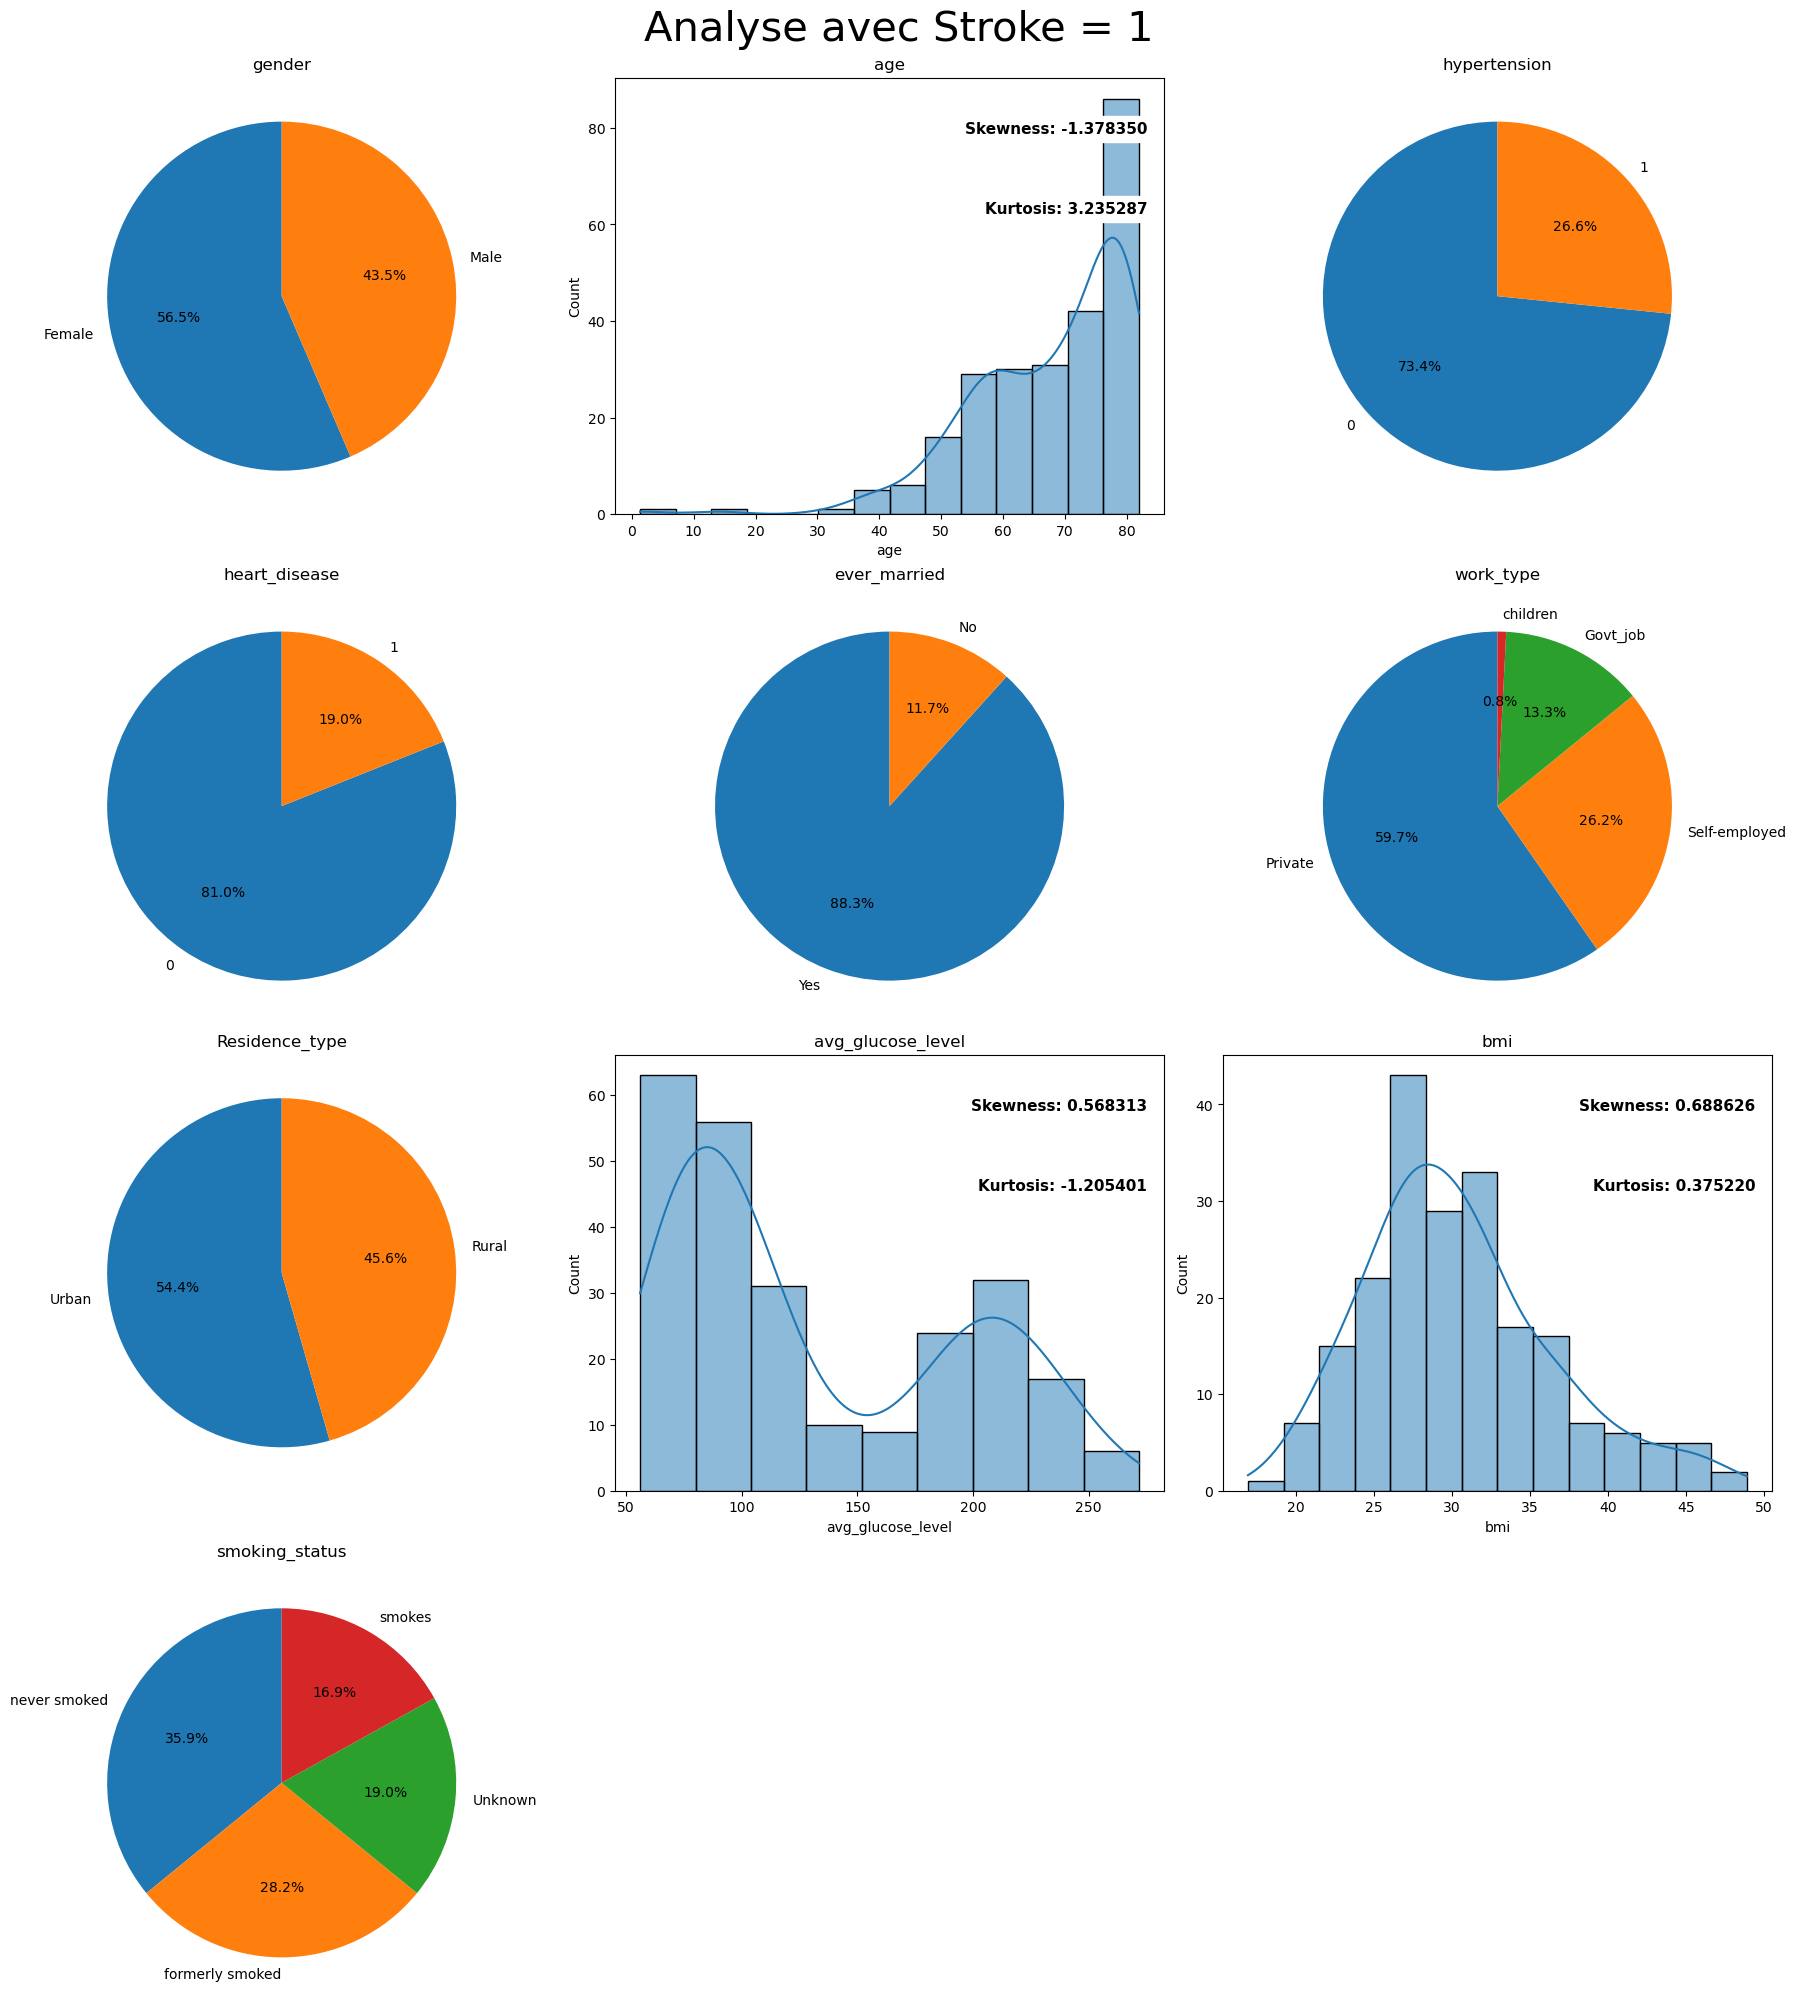

In [18]:
columns = df_1.columns[1:]

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 20), constrained_layout=True)
plt.suptitle("Analyse avec Stroke = 1", fontsize=30)


for i, column in enumerate(columns):
    row = i // 3
    col = i % 3

    if df_1[column].dtype == 'object' or df_1[column].dtype == 'int64':
        proportions = df_1[column].value_counts(normalize=True)
        axes[row, col].pie(proportions, labels=proportions.index, autopct='%1.1f%%', startangle=90)
        axes[row, col].set_title(f'{column}')
    else:
        sns.histplot(x=column, data=df_1, kde=True, ax=axes[row, col])
        axes[row, col].set_title(f'{column}')
        skewness = df_1[column].skew()
        kurt = df_1[column].kurt()
        if not pd.isnull(skewness) and not pd.isnull(kurt):
            axes[row, col].text(x=0.97, y=0.90, transform=axes[row, col].transAxes,
                                s="Skewness: %f" % skewness,
                                fontweight='demibold', fontsize=11, verticalalignment='top',
                                horizontalalignment='right', backgroundcolor='white')
            axes[row, col].text(x=0.97, y=0.70, transform=axes[row, col].transAxes,
                                s="Kurtosis: %f" % kurt,
                                fontweight='demibold', fontsize=11, verticalalignment='center',
                                horizontalalignment='right', backgroundcolor='white')

fig.delaxes(axes[3, 2])
fig.delaxes(axes[3, 1])
plt.show()


**Observartions des données des personnes classés 1 (avc):**
* La colonne 'gender' comprend 56% de femmes.
* La colonne âge indique une asymétrie à droite avec un skewness à -1.37 et un applatissement plus haut que pour une distribution normale. 
* 73% des personnes de ce groupe n'ont pas d'hypertension
* 81% des personnes de ce groupe n'ont pas de maladies cardiaques
* 88% des personnes ont déjà été mariés
* 59% des personnes travaillent dans le secteur privé
* 55% des personnes vivent en région urbaine
* La colonne avg_glucose est de type bimodale ce qui sous entend qu'il y a 2 sous ensembles au sein de cette catégorie (une concentration entre 50 et 150 et une autre entre 150 et 250)
* Pour la colonne bmi, les valeurs suggèrent une distribution légèrement asymétrique vers la droite, avec une concentration de valeurs plus importante autour de la moyenne et des extrémités plus épaisses que dans une distribution normale. Le score du kurtosis relativement faible indique que la distribution a des pics qui ne sont pas très élevés par rapport à une distribution normale.
* 36% des personnes de ce groupe n'ont jamais fumé et 28% sont des anciens fumeurs.

Nos deux groupes présentent des caractéristiques différentes. C'est pour cette raison que l'on a choisi d'utiliser la méthode d'imputation KNN Imputer.

In [19]:
df_nan = df.loc[df['bmi'].isna(),:]

Pour imputer les valeurs manquantes, On décide de commencer par encoder les variables catégorielles puis on standardise les valeurs afin d'appliquer un KNNImputer.

2. Encodage/Normalisation des données et imputation des features bmi et smoking_status

***2.1 Encodage***

**Définition: un encodeur est utilisé pour convertir des variables catégorielles en une variable numérique afin de pouvoir les utiliser sur des modèles de machine learning, qui travaillent généralement avec des données numériques.**. 

Il existe différents type d'encodeurs:  

**LabelEncoder:**  

Il convertit chaque classe unique d'une variable catégorielle en un nombre entier. Utile lorsque l'ordre des catégories n'a pas d'importance.  

**OneHotEncoder:** 

Il crée une colonne binaire distincte pour chaque catégorie unique. Utile lorsque l'ordre des catégories n'a pas d'importance.  

**OrdinalEncoder:**

Il ressemble au LabelEncoder, mais avec la possibilité de spécifier un ordre explicite des catégories.

On décide d'utiliser le One Hot Encodeur.

2.2 Standardisation (normalisation)

La standardisation des données, également appelée *normalisation*, fait référence au processus de transformation des données brutes en une forme standardisée. La plupart du temps, cela implique de procéder à la modification des données afin que ces dernières obtiennent **une moyenne de zéro et un écart-type de un**.

Pour pouvoir utiliser le KNN Imputer, je dois aussi mettre à l'échelle mes données.  
Sklearn propose 3 types de standardiseurs :  
* **Standard Scaler** : Il standardise les données en les centrant autour de zéro (moyenne = 0) et en les mettant à l'échelle en fonction de l'écart type.   
* **Min Max Scaler** : Il met à l'échelle les données dans une plage spécifique, généralement entre 0 et 1. Il est utile lorsque les données ont une distribution non normale ou avec des algorithmes sensibles à l'échelle.  
* **Robust Scaler** : Il utilise des statistiques robustes en éliminant les médianes et en échelonnant les données en fonction des quantiles. Cela le rend robuste aux valeurs aberrantes.

2.3 Imputation de la feature bmi

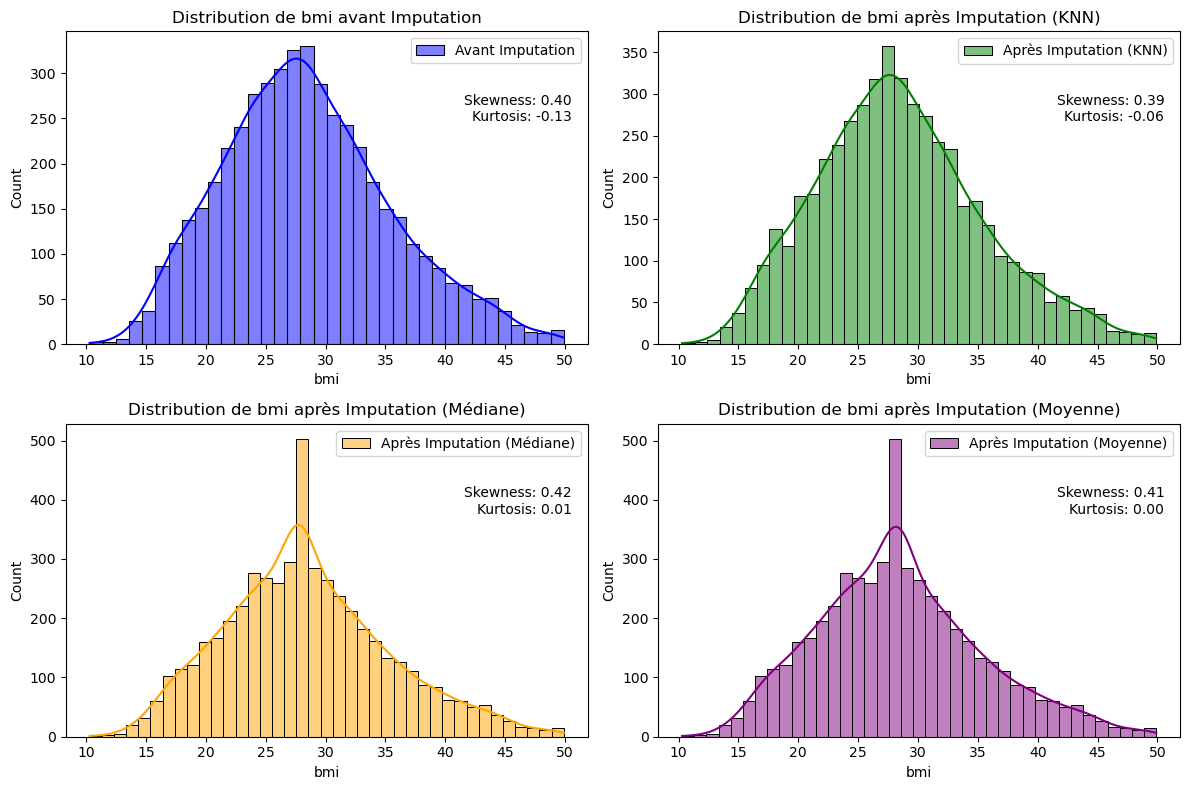

In [20]:
df_knn_imputed = impute_and_plot(df_0, df_1, df)

En comparant les différentes méthodes d'imputations, on décide de garder le KNNImputer car ses scores skewness et Kurtosis sont ceux qui sont les plus proches de la distribution avant imputation.

In [21]:
df.set_index('id', inplace=True)
df_knn_imputed.set_index('id',inplace=True)
df_index = df.index

df['bmi'] = df_knn_imputed['bmi'].values

df.index = df_index

2.4 Imputation de la feature smoking_status

In [22]:
unknown = df.loc[df['smoking_status']=='Unknown'][['gender','age','hypertension','heart_disease','ever_married','work_type','Residence_type','avg_glucose_level','bmi','stroke']]

In [23]:
unknown['stroke'].value_counts()

stroke
0    1476
1      47
Name: count, dtype: int64

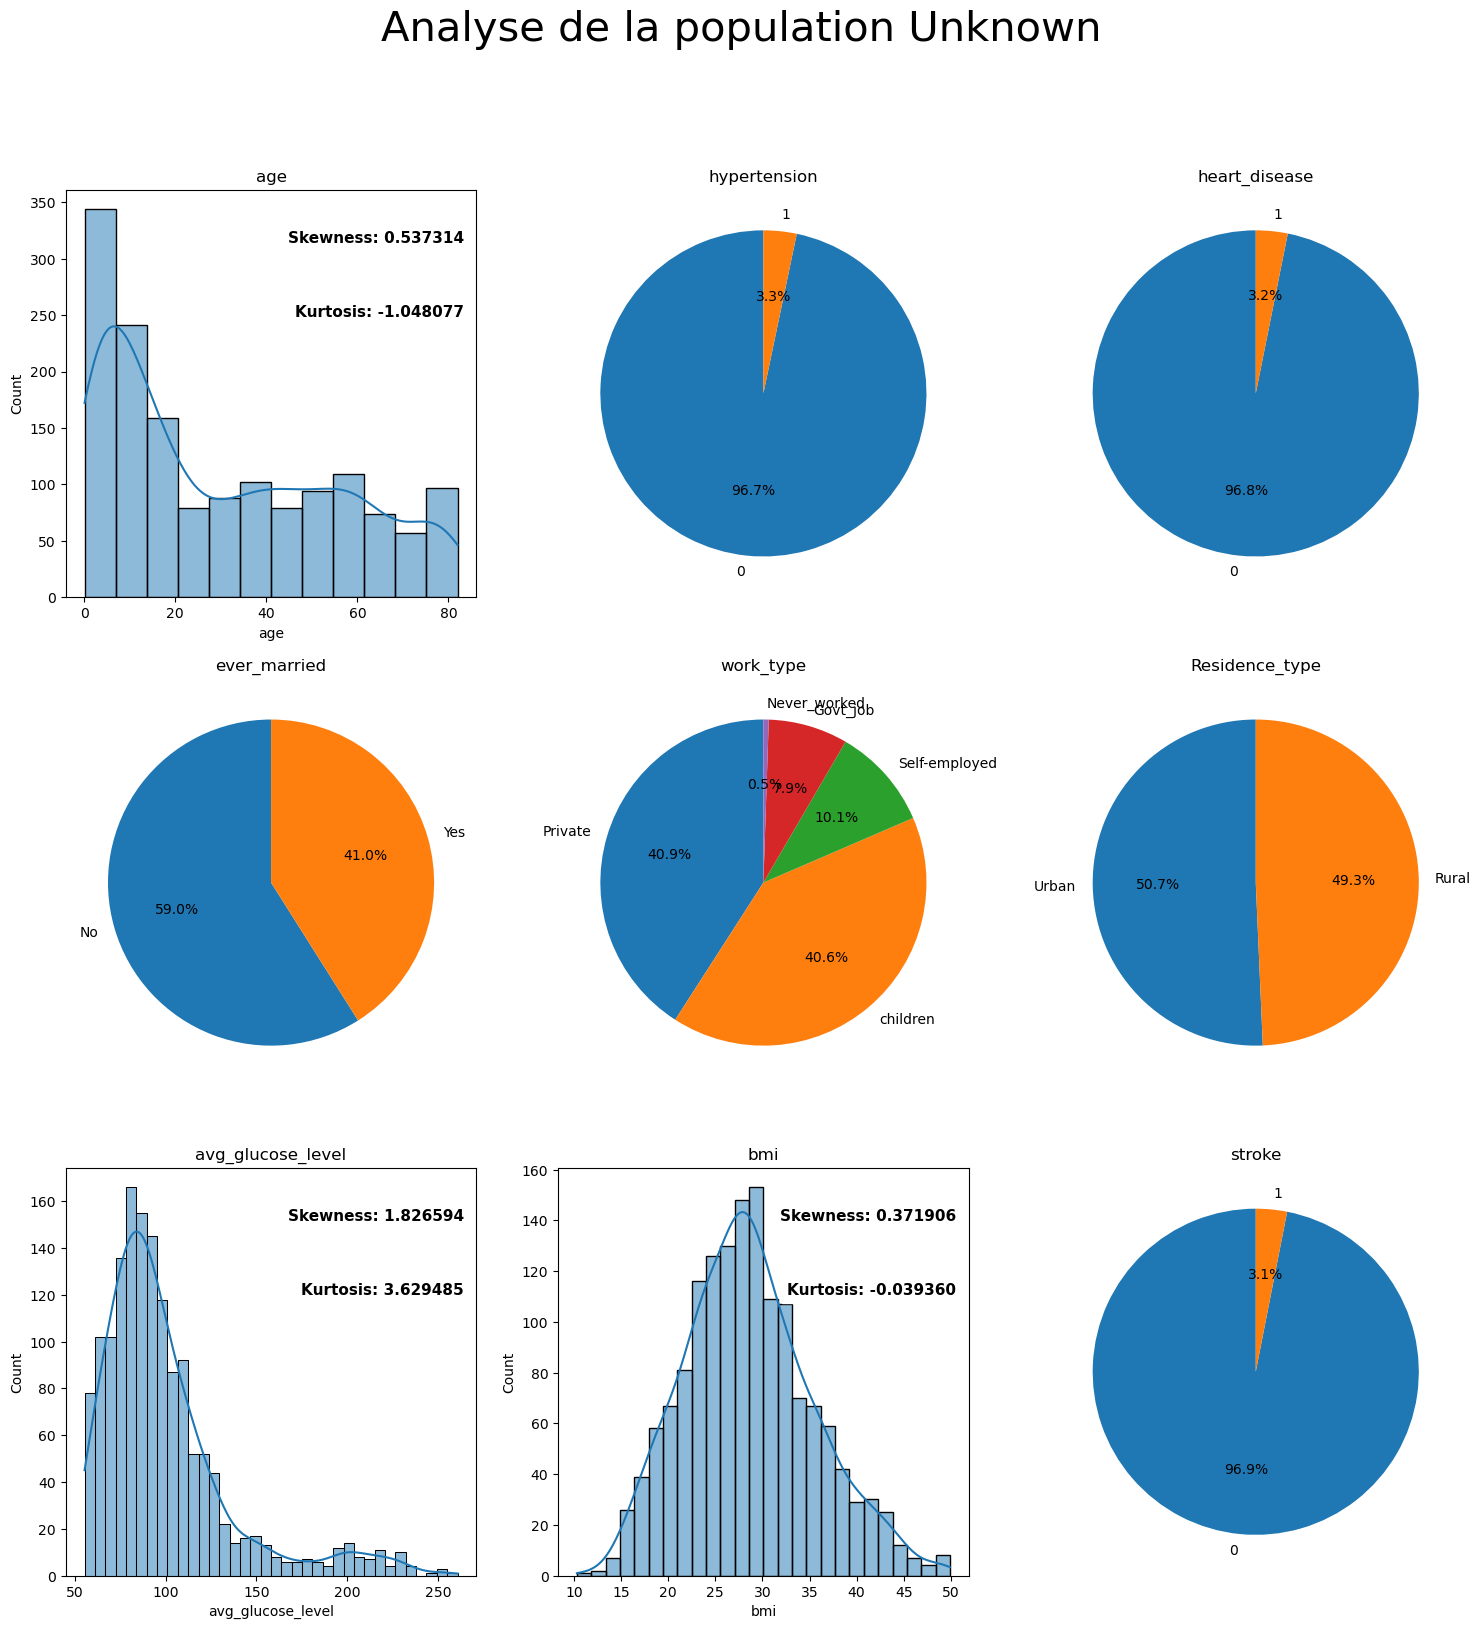

In [24]:
columns = unknown.columns[1:]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 18))
plt.suptitle('Analyse de la population Unknown', fontsize=30)

for i, column in enumerate(columns):
    row = i // 3
    col = i % 3

    if unknown[column].dtype == 'object' or unknown[column].dtype == 'int64':
        proportions = unknown[column].value_counts(normalize=True)
        axes[row, col].pie(proportions, labels=proportions.index, autopct='%1.1f%%', startangle=90)
        axes[row, col].set_title(f'{column}')
    else:
        sns.histplot(x=column, data=unknown, kde=True, ax=axes[row, col])
        axes[row, col].set_title(f'{column}')
        skewness = unknown[column].skew()
        kurt = unknown[column].kurt()
        if not pd.isnull(skewness) and not pd.isnull(kurt):
            axes[row, col].text(x=0.97, y=0.90, transform=axes[row, col].transAxes,
                                s="Skewness: %f" % skewness,
                                fontweight='demibold', fontsize=11, verticalalignment='top',
                                horizontalalignment='right', backgroundcolor='white')
            axes[row, col].text(x=0.97, y=0.70, transform=axes[row, col].transAxes,
                                s="Kurtosis: %f" % kurt,
                                fontweight='demibold', fontsize=11, verticalalignment='center',
                                horizontalalignment='right', backgroundcolor='white')


#plt.tight_layout()
plt.show()


**Observations:**  
* Une grande proportion des individus dans ce jeu sont des enfants, il sera facile d'imputer la valeur manquante de smoking status par 'Never smoked'
* Vérifier la colonne work_type qui semble contenir des informations errronées. (enfant de 7 ans noté comme 'self-employed'). 

In [25]:
df['smoking_status'].value_counts()

smoking_status
never smoked       1859
Unknown            1523
formerly smoked     871
smokes              777
Name: count, dtype: int64

In [26]:
df.loc[(df['age']<17)&(df['smoking_status']=='Unknown'),'smoking_status']='never smoked'
df.loc[(df['work_type']=="children"),'smoking_status']='never smoked'


In [27]:
df['smoking_status'].value_counts()

smoking_status
never smoked       2531
Unknown             866
formerly smoked     858
smokes              775
Name: count, dtype: int64

In [28]:
df.loc[df['age']<14]['work_type'].value_counts()

work_type
children         630
Private           10
Never_worked       3
Self-employed      2
Name: count, dtype: int64

In [29]:
df.loc[df['age']<14,'work_type']='children'
df.loc[df['work_type']=='children','smoking_status']='never smoked'

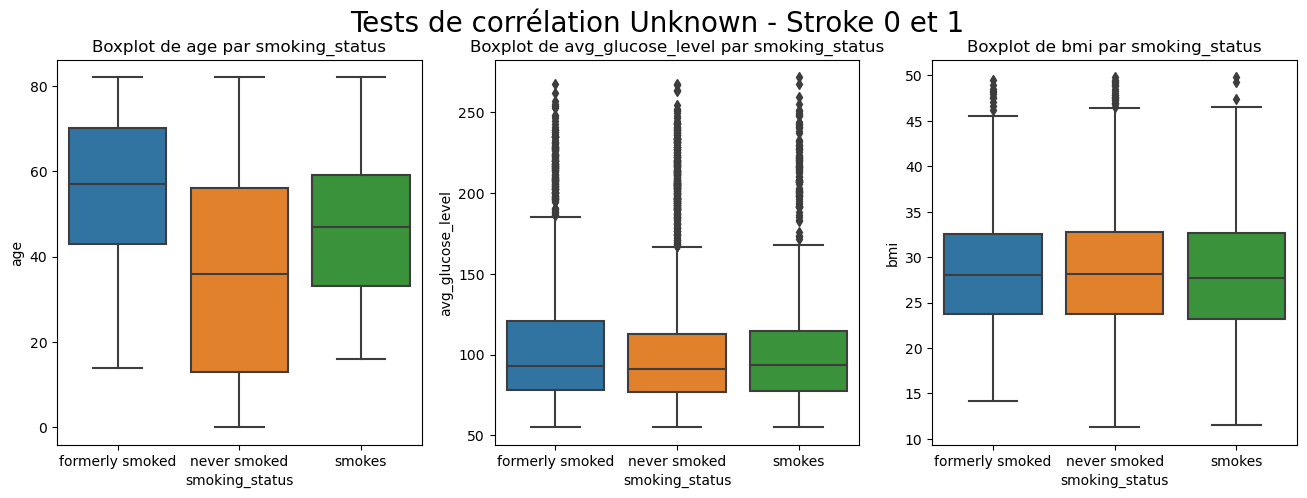

Variable: age
Statistique F : 280.2725351827424
p-valeur : 6.438654265547958e-115

Variable: avg_glucose_level
Statistique F : 14.049590926998032
p-valeur : 8.295644268568247e-07

Variable: bmi
Statistique F : 1.0211327609122602
p-valeur : 0.3602769451638911


Variable catégorielle: gender
Statistique du test du khi-deux d'indépendance : 11.611151525101784
************** p-valeur : 0.0030107207936772226



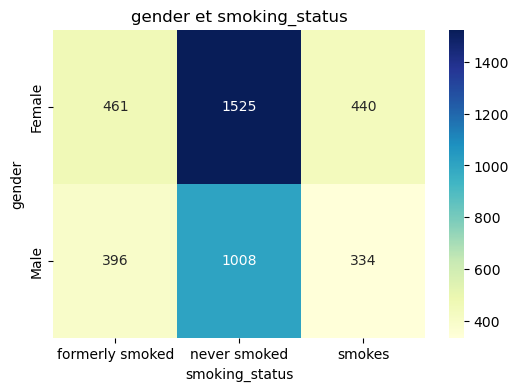


Variable catégorielle: hypertension
Statistique du test du khi-deux d'indépendance : 16.22645141181306
************** p-valeur : 0.0002995510494835941



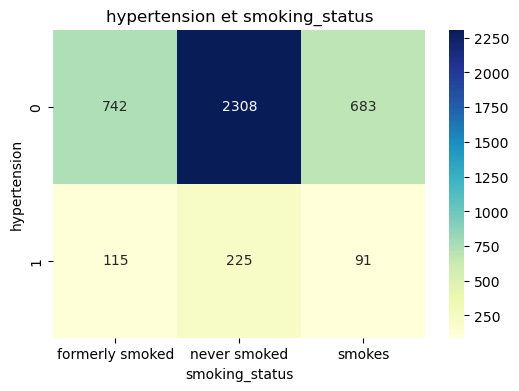


Variable catégorielle: heart_disease
Statistique du test du khi-deux d'indépendance : 47.13287011138762
************** p-valeur : 5.82407953510398e-11



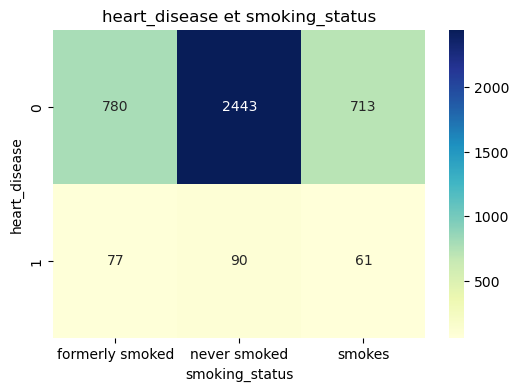


Variable catégorielle: ever_married
Statistique du test du khi-deux d'indépendance : 365.3439113331855
************** p-valeur : 4.6406376108593305e-80



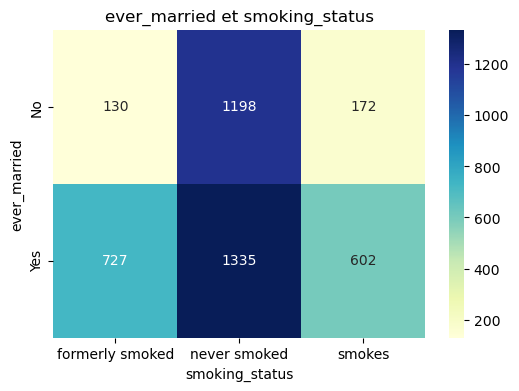


Variable catégorielle: work_type
Statistique du test du khi-deux d'indépendance : 582.2636414501945
************** p-valeur : 1.5193484951617668e-120



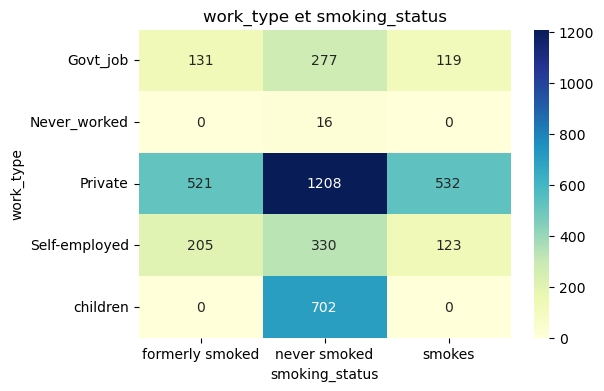


Variable catégorielle: Residence_type
Statistique du test du khi-deux d'indépendance : 5.7904197021818575
************** p-valeur : 0.05528742175147765



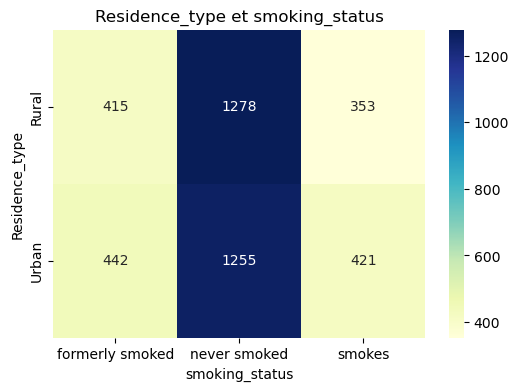


Variable catégorielle: smoking_status
Statistique du test du khi-deux d'indépendance : 8328.0
************** p-valeur : 0.0



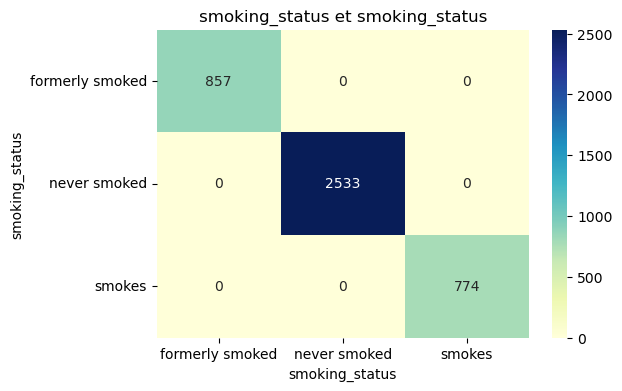

In [30]:
df_no_unknown_0 = df.loc[(df['smoking_status'] != 'Unknown') & (df['stroke'] == 0), :]
df_no_unknown_1 = df.loc[(df['smoking_status'] != 'Unknown') & (df['stroke'] == 1), :]
df_unknown = df.loc[(df['smoking_status'] != 'Unknown'),:]


numeric_columns = df_unknown.select_dtypes(include='float').columns

plt.figure(figsize=(16, 5))
plt.suptitle("Tests de corrélation Unknown - Stroke 0 et 1", fontsize=20)
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='smoking_status', y=column, data=df_unknown)
    plt.title(f'Boxplot de {column} par smoking_status')

plt.show()

for column in numeric_columns:
    groups = [group_data[column].dropna() for group, group_data in df_unknown.groupby('smoking_status')]
    f_statistic, p_value = f_oneway(*groups)

    print(f"Variable: {column}")
    print(f"Statistique F : {f_statistic}")
    print(f"p-valeur : {p_value}")
    print("")


categorical_columns = df_unknown.select_dtypes(include=['object','int']).columns
for column in categorical_columns[:-1]:
    contingency_table = pd.crosstab(df_unknown[column], df_unknown['smoking_status'])
    print("")
    chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)
    print(f"Variable catégorielle: {column}")
    print(f"Statistique du test du khi-deux d'indépendance : {chi2_stat}")
    print(f"************** p-valeur : {p_val}")
    print("")

    plt.figure(figsize=(6, 4))
    sns.heatmap(contingency_table, annot=True, cmap="YlGnBu", fmt="d")
    plt.title(f'{column} et smoking_status')
    plt.xlabel('smoking_status')
    plt.ylabel(column)
    plt.show()


On réalise des tests anova et de khi2 afin de déterminer quelles variables sont corrélées à la colonne smoking_status.  
**Colonnes corrélées :**
* Age
* Avg_glucose_level
* gender
* hypertension
* heart_disease
* ever_married
* work_type

In [31]:
df_copy = df.copy()
bins = [0, 20, 30, 40, 50, 60, 80,float('inf')]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-80','81+']

df_copy['age_cat'] = pd.cut(df_copy['age'], bins=bins, labels=labels, right=False)
df_copy['age_cat'] = df_copy['age_cat'].astype('object')

df_copy['smoking_status'] = df_copy['smoking_status'].replace('Unknown', np.nan)

In [32]:
df_copy['work_type'].value_counts(normalize=True)

work_type
Private          0.567793
Self-employed    0.160437
children         0.139563
Govt_job         0.128429
Never_worked     0.003777
Name: proportion, dtype: float64

* 56% des individus travaillent dans le secteur privé.  

In [33]:
df_sans_child = df_copy.loc[(df_copy["work_type"]!='children')&(~df_copy["smoking_status"].isna()),:]

On effectue une nouvelle analyse en retirant les enfants afin de diminuer la part de non-fumeurs et ainsi voir si cela va modifier le mode qui actuellement est **'Never Smoked'**

In [34]:
df_sans_child.groupby('smoking_status')['work_type'].value_counts()

smoking_status   work_type    
formerly smoked  Private           521
                 Self-employed     205
                 Govt_job          131
never smoked     Private          1208
                 Self-employed     330
                 Govt_job          277
                 Never_worked       16
smokes           Private           532
                 Self-employed     123
                 Govt_job          119
Name: count, dtype: int64

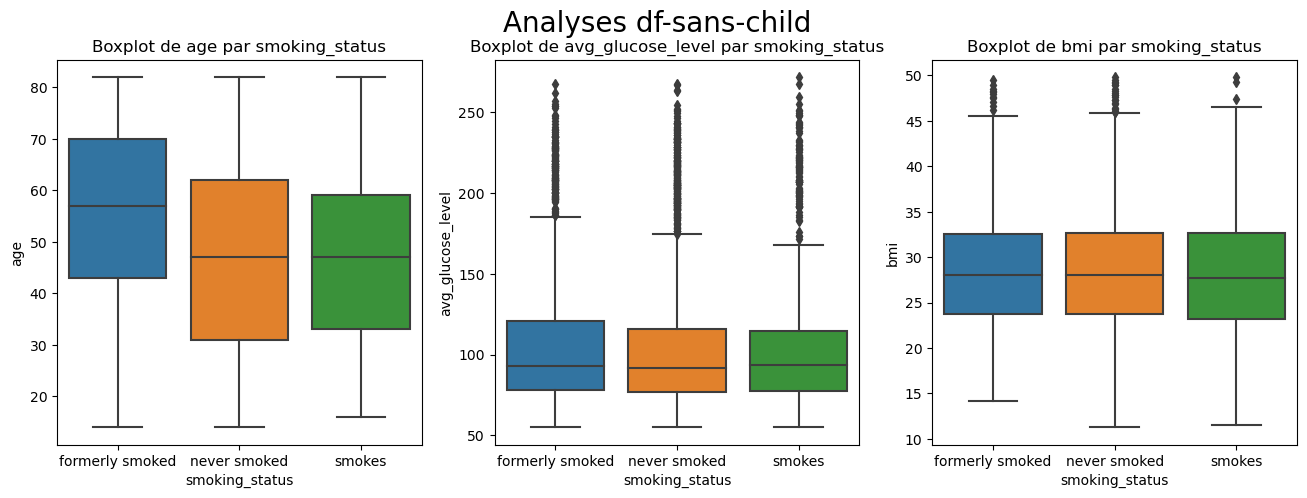

Variable: age
Statistique F : 67.84088675858587
p-valeur : 1.2596485244522114e-29

Variable: avg_glucose_level
Statistique F : 4.4264786889624075
p-valeur : 0.012024322860751245

Variable: bmi
Statistique F : 0.8033048394276867
p-valeur : 0.4479299856765372


Variable catégorielle: gender
Statistique du test du khi-deux d'indépendance : 36.659089207671734
************** p-valeur : 1.095418125458829e-08



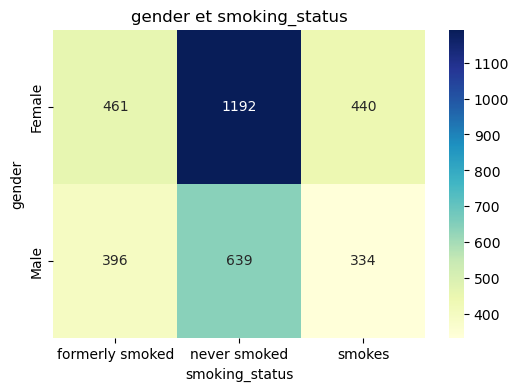


Variable catégorielle: hypertension
Statistique du test du khi-deux d'indépendance : 1.1229460043317925
************** p-valeur : 0.5703682910426895



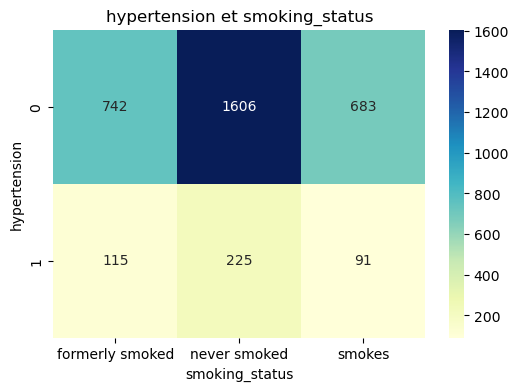


Variable catégorielle: heart_disease
Statistique du test du khi-deux d'indépendance : 19.058244062082665
************** p-valeur : 7.27034273320638e-05



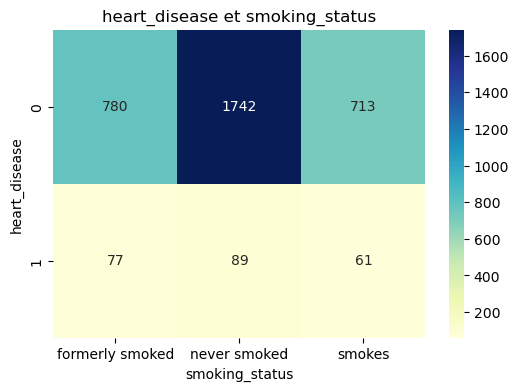


Variable catégorielle: ever_married
Statistique du test du khi-deux d'indépendance : 47.147757865310815
************** p-valeur : 5.780886763914416e-11



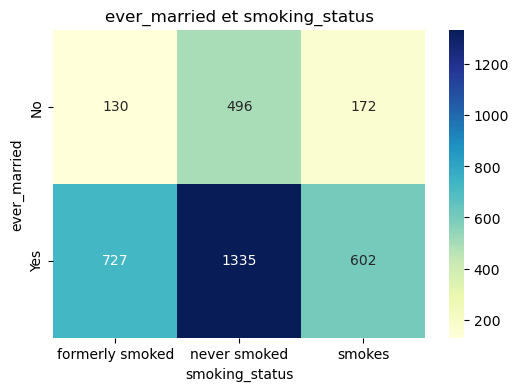


Variable catégorielle: work_type
Statistique du test du khi-deux d'indépendance : 34.239341782276774
************** p-valeur : 6.048013788373141e-06



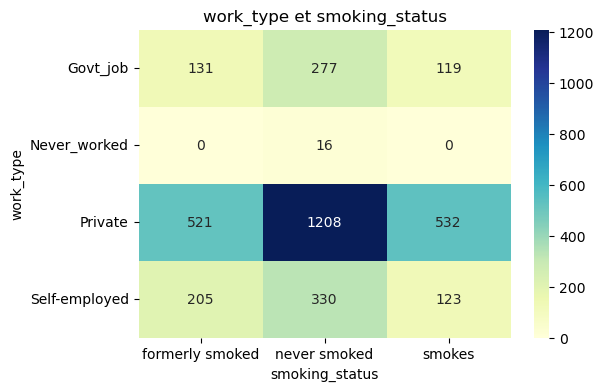


Variable catégorielle: Residence_type
Statistique du test du khi-deux d'indépendance : 6.1686287668879505
************** p-valeur : 0.04576139791918455



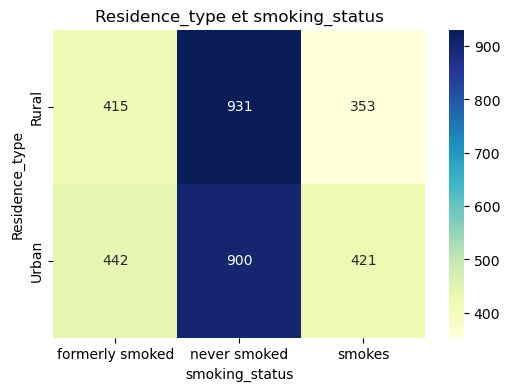


Variable catégorielle: smoking_status
Statistique du test du khi-deux d'indépendance : 6924.0
************** p-valeur : 0.0



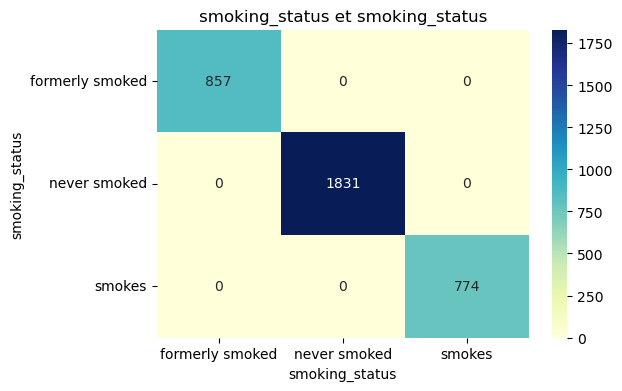


Variable catégorielle: stroke
Statistique du test du khi-deux d'indépendance : 11.93855422603554
************** p-valeur : 0.002556088514404439



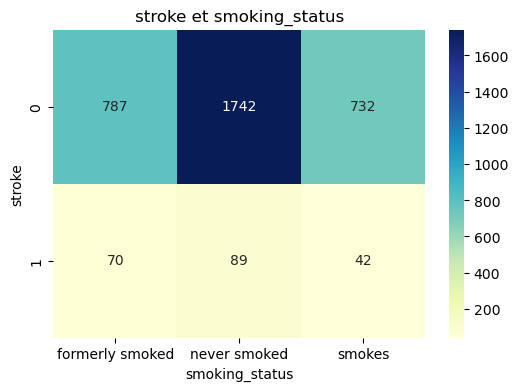


Variable catégorielle: age_cat
Statistique du test du khi-deux d'indépendance : 197.7765438890342
************** p-valeur : 9.38003321270563e-36



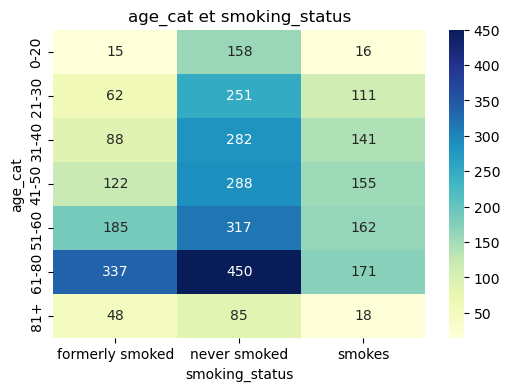

In [35]:
numeric_columns = df_sans_child.select_dtypes(include='float').columns

plt.figure(figsize=(16, 5))
plt.suptitle("Analyses df-sans-child", fontsize=20)
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='smoking_status', y=column, data=df_sans_child)
    plt.title(f'Boxplot de {column} par smoking_status')

plt.show()

for column in numeric_columns:
    groups = [group_data[column].dropna() for group, group_data in df_sans_child.groupby('smoking_status')]
    f_statistic, p_value = f_oneway(*groups)

    print(f"Variable: {column}")
    print(f"Statistique F : {f_statistic}")
    print(f"p-valeur : {p_value}")
    print("")


categorical_columns = df_sans_child.select_dtypes(include=['object','int']).columns
for column in categorical_columns:
    contingency_table = pd.crosstab(df_sans_child[column], df_sans_child['smoking_status'])
    print("")
    chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)
    print(f"Variable catégorielle: {column}")
    print(f"Statistique du test du khi-deux d'indépendance : {chi2_stat}")
    print(f"************** p-valeur : {p_val}")
    print("")
    plt.figure(figsize=(6, 4))
    sns.heatmap(contingency_table, annot=True, cmap="YlGnBu", fmt="d")
    plt.title(f'{column} et smoking_status')
    plt.xlabel('smoking_status')
    plt.ylabel(column)
    plt.show()


Les différents tests effectués indiquent que malgré le retrait de la classe 'children', la majorité des individus de ce jeu de données sont de type **non fumeur**.  

La méthode d'imputation par le mode (la classe la plus fréquente) indique que c'est cette classe qui sera imputée aux valeurs manquantes de la colonne smoking_status.  
Toutefois, le test khi2 entre la variable age_cat et smoking_status révèle une part importante de fumeur entre 61 et 80 ans.  

Je décide d'imputer cette catégorie en tant que fumeurs et le reste sera imputé par non fumeur.


In [36]:
df_copy.loc[(df_copy['age_cat']=='61-80')&(df_copy['smoking_status'].isna()),'smoking_status']='smokes'
df_copy_1 = df_copy.loc[df_copy['ever_married']=='Yes',:]
df_copy_0 = df_copy.loc[df_copy['ever_married']=='No',:]

column_with_missing_values = 'smoking_status'

mode_value_0 = df_copy_0[column_with_missing_values].mode()[0]
mode_value_1 = df_copy_1[column_with_missing_values].mode()[0]

df_copy_0[column_with_missing_values].fillna(mode_value_0, inplace=True)
df_copy_1[column_with_missing_values].fillna(mode_value_1, inplace=True)

print(mode_value_0)
print(mode_value_1)

never smoked
never smoked


In [37]:
df_cleaned = pd.concat([df_copy_0,df_copy_1],axis=0)

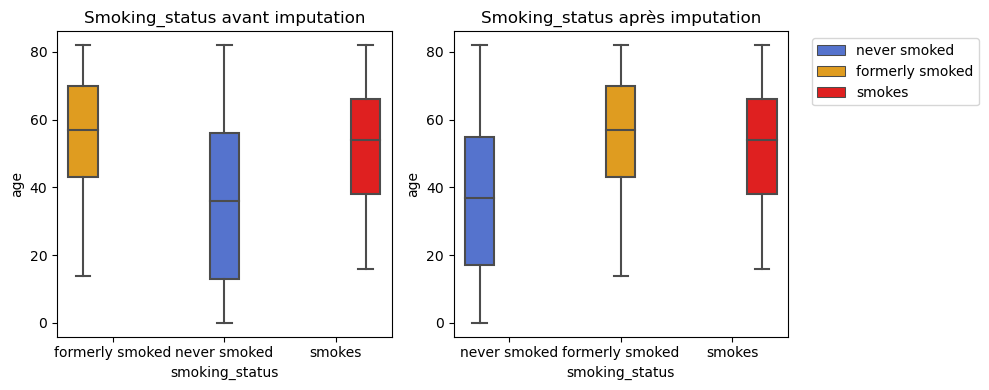

In [38]:
palette = {'smokes': 'red', 'never smoked': 'royalblue', 'formerly smoked': 'orange'}
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.boxplot(data=df_copy, x='smoking_status', y='age', hue='smoking_status', palette=palette, ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_title('Smoking_status avant imputation')

sns.boxplot(data=df_cleaned, x='smoking_status', y='age', hue='smoking_status', palette=palette, ax=axes[1])
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].set_title('Smoking_status après imputation')

plt.tight_layout()
plt.show()

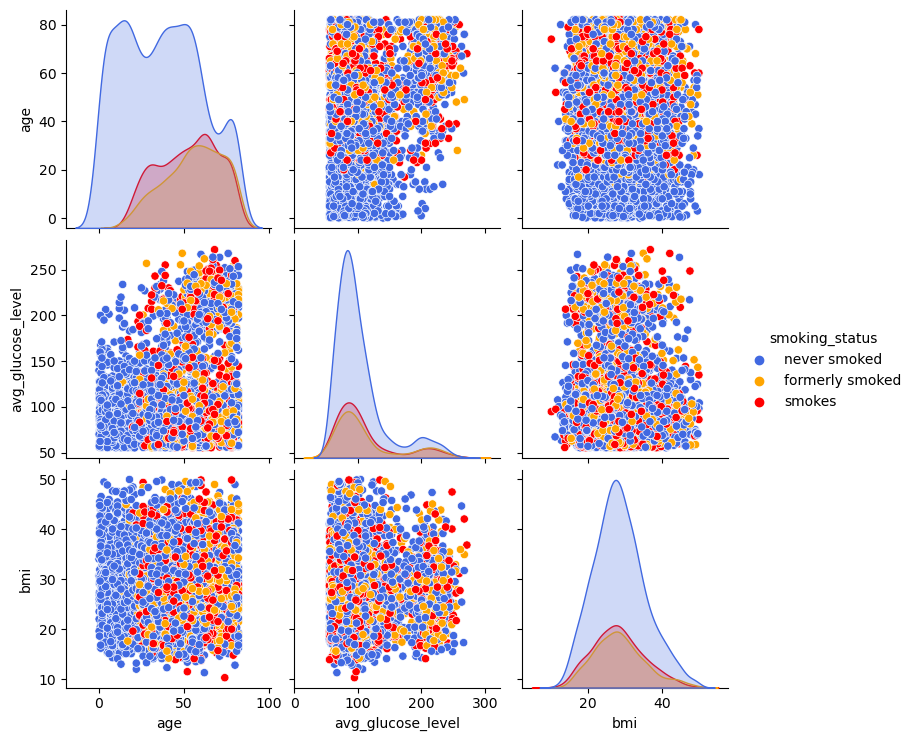

In [39]:
sns.pairplot(data=df_cleaned.select_dtypes(exclude='int'),hue='smoking_status',palette=palette)

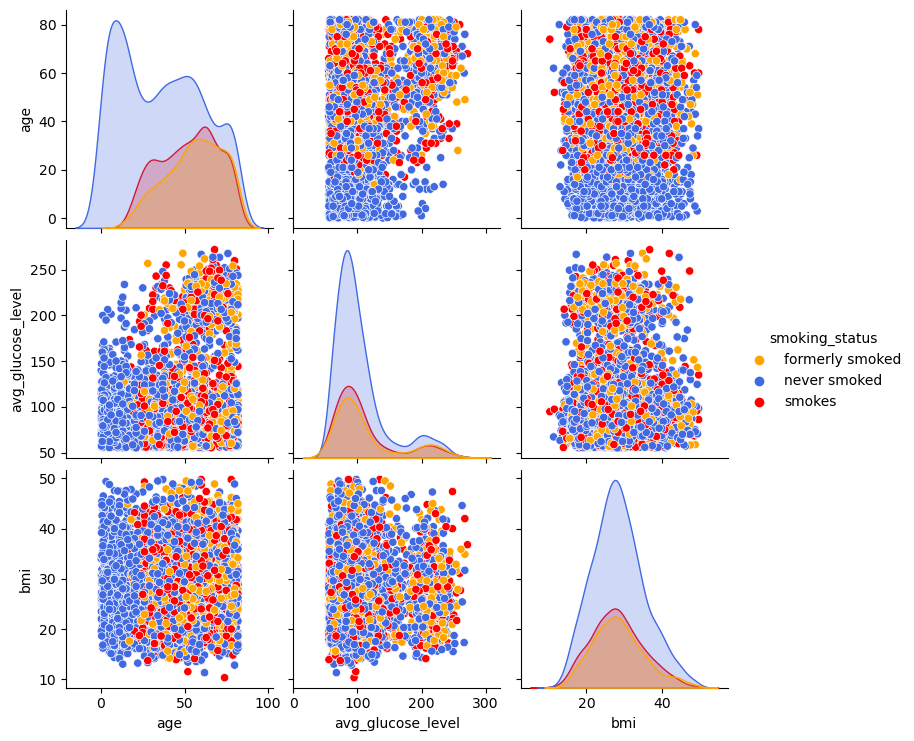

In [40]:
sns.pairplot(data=df_copy.select_dtypes(exclude='int'),hue='smoking_status',palette=palette)

L'imputation semble correcte car nous retrouvons le même type de distribution entre les catégories de smoking_status avant et après imputation par rapport aux autres variables même si il faut noter une modification de la distribution de la colonne âge.

In [41]:
df_cleaned.to_csv('df_cleaned.csv')

In [42]:
df_cleaned = df_cleaned.drop('age_cat',axis=1)

**3. Sélection d'une feature pour le modèle**

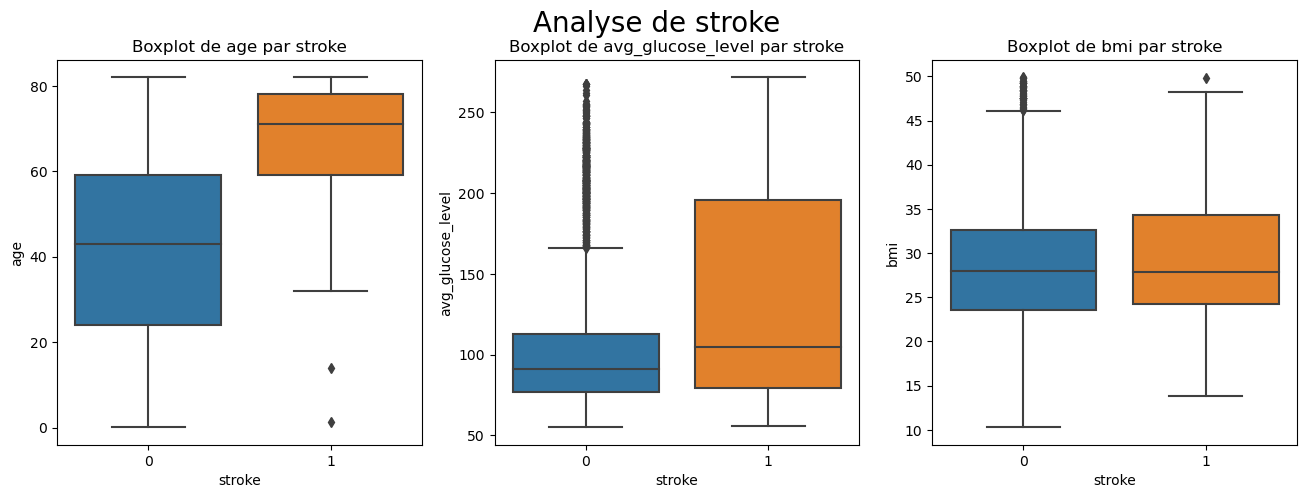

Variable: age
Statistique F : 326.0521303594669
p-valeur : 1.1409289434076173e-70

Variable: avg_glucose_level
Statistique F : 90.65140098168436
p-valeur : 2.5887643869045003e-21

Variable: bmi
Statistique F : 1.9344666624528153
p-valeur : 0.16433214425376008


Variable catégorielle: gender
Statistique du test du khi-deux d'indépendance : 0.308994781740602
************** p-valeur : 0.5782976834204623



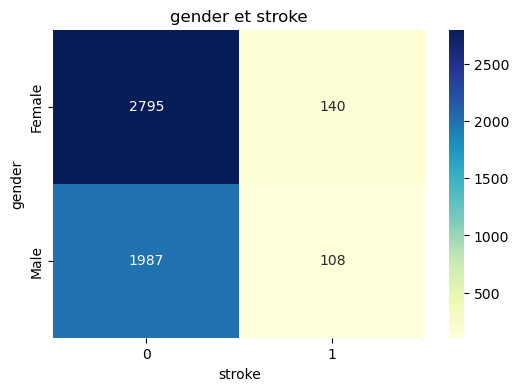


Variable catégorielle: hypertension
Statistique du test du khi-deux d'indépendance : 85.6280584364618
************** p-valeur : 2.171719326965917e-20



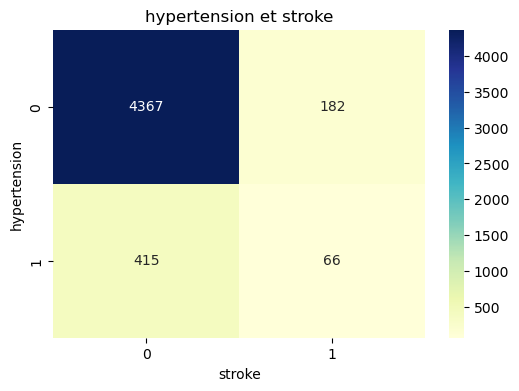


Variable catégorielle: heart_disease
Statistique du test du khi-deux d'indépendance : 89.05172245892625
************** p-valeur : 3.846237220525364e-21



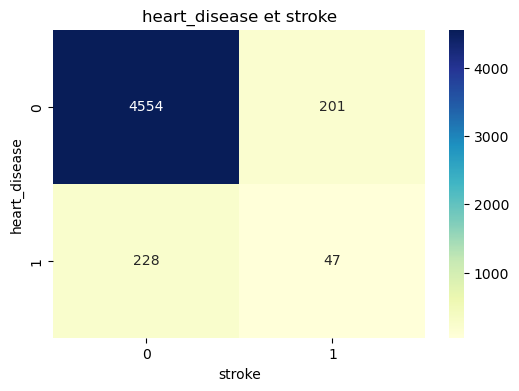


Variable catégorielle: ever_married
Statistique du test du khi-deux d'indépendance : 59.48283717259807
************** p-valeur : 1.233653357267473e-14



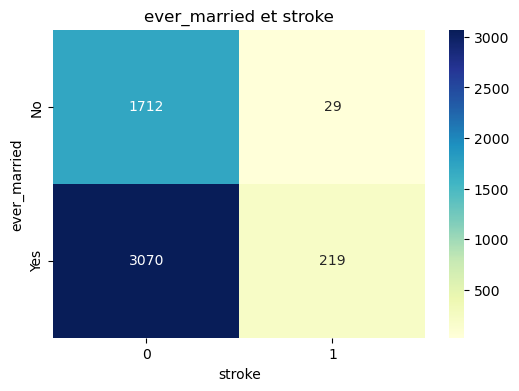


Variable catégorielle: work_type
Statistique du test du khi-deux d'indépendance : 50.53900984570352
************** p-valeur : 2.786412050692571e-10



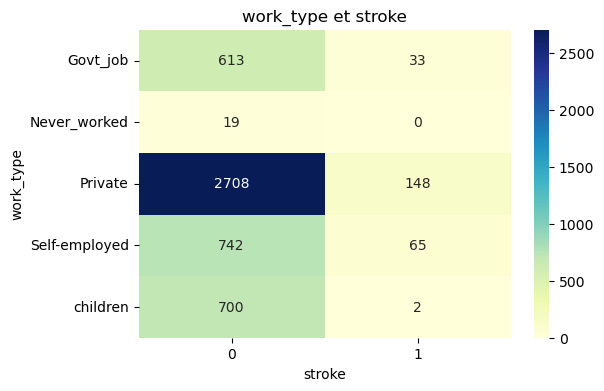


Variable catégorielle: Residence_type
Statistique du test du khi-deux d'indépendance : 1.1638689751076743
************** p-valeur : 0.28066459183194536



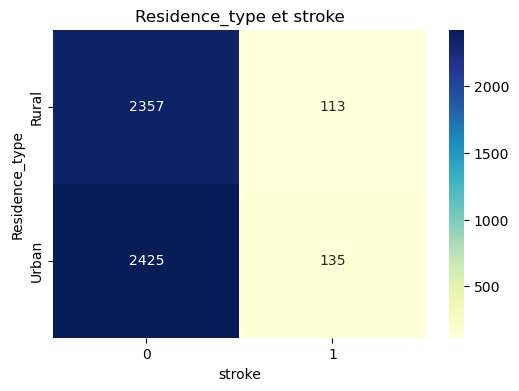

In [43]:
numeric_columns = df_cleaned.select_dtypes(include='float').columns

plt.figure(figsize=(16, 5))
plt.suptitle("Analyse de stroke", fontsize=20)
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='stroke', y=column, data=df_cleaned)
    plt.title(f'Boxplot de {column} par stroke')

plt.show()

for column in numeric_columns:
    groups = [group_data[column].dropna() for group, group_data in df_cleaned.groupby('stroke')]
    f_statistic, p_value = f_oneway(*groups)

    print(f"Variable: {column}")
    print(f"Statistique F : {f_statistic}")
    print(f"p-valeur : {p_value}")
    print("")


categorical_columns = df_cleaned.select_dtypes(include=['object','int']).columns[:-1]
for column in categorical_columns[:-1]:
    contingency_table = pd.crosstab(df_cleaned[column], df_cleaned['stroke'])
    print("")
    chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)
    print(f"Variable catégorielle: {column}")
    print(f"Statistique du test du khi-deux d'indépendance : {chi2_stat}")
    print(f"************** p-valeur : {p_val}")
    print("")
    plt.figure(figsize=(6, 4))
    sns.heatmap(contingency_table, annot=True, cmap="YlGnBu", fmt="d")
    plt.title(f'{column} et stroke')
    plt.xlabel('stroke')
    plt.ylabel(column)
    plt.show()


Les tests de corrélation montre que les features **hypertension et heart_disease** indiquent une forte corrélation et peuvent être utilisées pour notre modèle.

**4. La classification supervisée**

La classification supervisée est un type d'apprentissage supervisé où l'algorithme est entrainé sur un dataset dit labélisé, la caractéristique(feature) que l'on va chercher à prédire doit déjà exister dans le jeu de données pour l'appliquer.

C'est donc un processus fondamentalement différent de l'apprentissage non supervisé où la caractéristique que l'on souhaite prédire n'existe pas dans le jeu de données.

Il existe également d'autres formes d'apprentissage en machine learning comme l'apprentissage semi-supervisé qui mêle les deux précédentes approches et l'apprentissage par renforcement qui se base sur un système de récompenses et pénalités accordées au model.

**4.1 La régression logistique**

La régression logistique est un modèle statistique permettant d’étudier les relations entre un ensemble de variables qualitatives Xi et une variable qualitative Y.
Il s’agit d’un modèle linéaire généralisé utilisant une fonction logistique comme fonction de lien. 

**4.2 random forest** 

Random forest aussi dit « forêt aléatoire », est un algorithme qui se base sur l’assemblage d’arbres de décision. Il est assez intuitif à comprendre, rapide à entraîner et il produit des résultats généralisables.

**4.3 SVM**

C'est une famille d'algorithmes d'apprentissage automatique qui permettent de résoudre des problèmes tant de classification que de régression ou de détection d'anomalie.


### **5. Comparaison de 3 modèles de classification**

* regression logistique
* random forest
* SVM

Pour pouvoir comparer mes modèles, je vais créer un fonction qui contiendra :  
* Création du modèle  
* Optimisation du seuil de classification pour maximiser l'AUC *(La ROC curve, aussi appelée courbe de sensitivité/spécificité, est une courbe de probabilité qui permet de visualiser la performance des modèles de classification. Il s’agit ici simplement du taux des True Positive (TPR) tracé en fonction du taux des False Negative (FPR). L’AUC, comprise entre 0 et 1, va elle représenter une mesure du degré de séparabilité des prédictions du modèle : un modèle avec une AUC proche de 1 prédira le plus souvent correctement les 0 comme des 0 et les 1 comme des 1.*)
* Affichage des features importances avant et après optimisation
* Affichage de la courbe ROC avant et après
* Affichage du rapport de classification avant et après optimisation
* Affichage de la matrice de confusion avant et après optimisation
* Utilisation de GridSearch CV *(GridSearchCV est un processus de réglage des hyperparamètres qui permet de déterminer les valeurs optimales pour un modèle.)* 
    

Je vais évaluer 3 modèles (Random Forest, la regression logistique et le SVM (support vector machine)) en testant différentes méthodes de sampling et de normalisation des données.

```python 
liste_col = ['age', 'bmi','smoking_status','avg_glucose_level', 'hypertension', 'heart_disease', 'ever_married', 'work_type']

liste_standardiseurs = [MinMaxScaler(), RobustScaler()]

liste_modes_preprocessing = ['undersampling', 'oversampling', None]

liste_modeles = ['RandomForest', 'LogisticRegression', 'SVM']

df_eval = pd.DataFrame(columns=['Modèle', 'Best accuracy', 'Best recall', 'Best cost', 'Best precision Score', 'True Positives', 'True Negatives', 'Sampling', 'Standardisation', 'Feature'])


for colonne in liste_col:
    for standardiseur in liste_standardiseurs:
        for mode_preprocessing in liste_modes_preprocessing:
            X_train, X_test, y_train, y_test, x_col = preprocessing(df_cleaned[[colonne,'stroke']], standardiser=standardiseur, mode=mode_preprocessing,nbr_feature=1)
            
            for modele in liste_modeles:
                if modele == 'RandomForest':
                    y_pred, y_proba, model, y_pred_best, y_proba_best, best_model, results, df_results = random_forest_sans_affichage(X_train, y_train, X_test, y_test, x_col, mode=mode_preprocessing, standardiser=standardiseur, feature=colonne)
                elif modele == 'LogisticRegression':
                    y_pred, y_proba, model, y_pred_best, y_proba_best, best_model, results, df_results = logistic_regression_sans_affichage(X_train, y_train, X_test, y_test, x_col, mode=mode_preprocessing, standardiser=standardiseur, feature=colonne)
                elif modele == 'SVM':
                    y_pred_best, y_proba_best, model, best_model, results, df_results = svm_classifier_sans_affichage(X_train, y_train, X_test, y_test, x_col, mode=mode_preprocessing, standardiser=standardiseur, feature=colonne)
                
                df_eval = pd.concat([df_eval, df_results], ignore_index=True)

df_eval.to_csv('resultats_modeles.csv', index=False)
``` 

La case de test des modèles a été désactivée car les évaluations des modèles sont disponibles dans le fichier csv 'resultats_modeles.csv.

In [45]:
df_eval.to_csv('resultats_modeles.csv', mode='a', index=False, header=not os.path.exists('resultats_modeles.csv'))
df_eval = pd.read_csv('resultats_modeles.csv')

In [46]:
df_eval= df_eval.drop(['Sampling','Standardisation','Feature'],axis=1)

In [47]:
df_eval.sort_values(['True Positives','True Negatives'],ascending=False)

Modèle  Best accuracy  Best recall  Best cost  \
2                    SVM           0.61         1.00        392   
146                  SVM           0.61         1.00        392   
5                    SVM           0.53         1.00        472   
149                  SVM           0.53         1.00        472   
11                   SVM           0.29         1.00        713   
155                  SVM           0.29         1.00        713   
126        Random forest           0.20         1.00        809   
127  Logistic Regression           0.20         1.00        809   
128                  SVM           0.20         1.00        809   
129        Random forest           0.20         1.00        809   
130  Logistic Regression           0.20         1.00        809   
131                  SVM           0.20         1.00        809   
132        Random forest           0.20         1.00        809   
133  Logistic Regression           0.20         1.00        809   
135        Random forest           0.20         1.00        809   
136  Logistic Regression           0.20         1.00        809   
137                  SVM           0.20         1.00        809   
138        Random forest           0.20         1.00        809   
139  Logistic Regression           0.20         1.00        809   
140                  SVM           0.20         1.00        809   
141        Random forest           0.20         1.00        809   
142  Logistic Regression           0.20         1.00        809   
270        Random forest           0.20         1.00        809   
271  Logistic Regression           0.20         1.00        809   
272                  SVM           0.20         1.00        809   
273        Random forest           0.20         1.00        809   
274  Logistic Regression           0.20         1.00        809   
275                  SVM           0.20         1.00        809   
276        Random forest           0.20         1.00        809   
277  Logistic Regression           0.20         1.00        809   
279        Random forest           0.20         1.00        809   
280  Logistic Regression           0.20         1.00        809   
281                  SVM           0.20         1.00        809   
282        Random forest           0.20         1.00        809   
283  Logistic Regression           0.20         1.00        809   
284                  SVM           0.20         1.00        809   
285        Random forest           0.20         1.00        809   
286  Logistic Regression           0.20         1.00        809   
14                   SVM           0.19         1.00        819   
158                  SVM           0.19         1.00        819   
24         Random forest           0.13         0.96        894   
33         Random forest           0.13         0.96        894   
168        Random forest           0.13         0.96        894   
177        Random forest           0.13         0.96        894   
0          Random forest           0.72         0.91        322   
1    Logistic Regression           0.72         0.91        322   
3          Random forest           0.72         0.91        322   
4    Logistic Regression           0.72         0.91        322   
6          Random forest           0.72         0.91        322   
7    Logistic Regression           0.72         0.91        322   
10   Logistic Regression           0.72         0.91        322   
13   Logistic Regression           0.72         0.91        322   
15         Random forest           0.72         0.91        322   
16   Logistic Regression           0.72         0.91        322   
144        Random forest           0.72         0.91        322   
145  Logistic Regression           0.72         0.91        322   
147        Random forest           0.72         0.91        322   
148  Logistic Regression           0.72         0.91        322   
150        Random forest           0.72         0.91        322  

Le meilleur ratio entre les True Positives et True negatives est celui de 41 / 679. 

In [48]:
X_train, X_test, y_train, y_test, x_col = preprocessing(df_cleaned[['age','stroke']],standardiser=RobustScaler(),mode='undersampling',nbr_feature=1)

**5.0 Dummy (baseline)**

Optimisation du seuil de classification pour maximiser l'AUC
Scores du modèle 
{'accuracy': 0.9552683896620279, 'f1_score': 0.0, 'precision': 0.0, 'recall': 0.0, 'auc': 0.5, 'cost': 450}
Affichage de la courbe Roc 


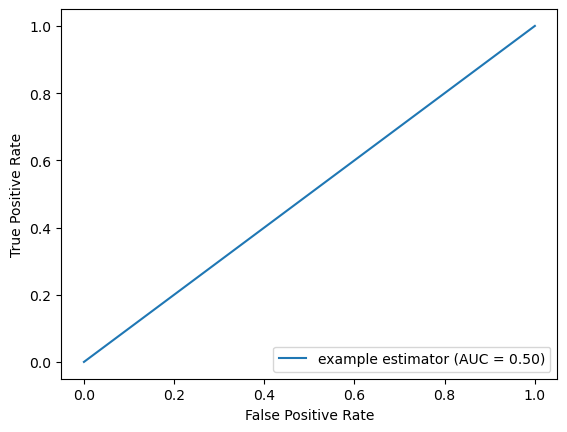

None
Affichage du rapport de classification 
              precision  recall  f1-score  support
0                  0.96    1.00      0.98   961.00
1                  0.00    0.00      0.00    45.00
accuracy           0.96    0.96      0.96     0.96
macro avg          0.48    0.50      0.49  1006.00
weighted avg       0.91    0.96      0.93  1006.00
None
Affichage de la matrice de confusion


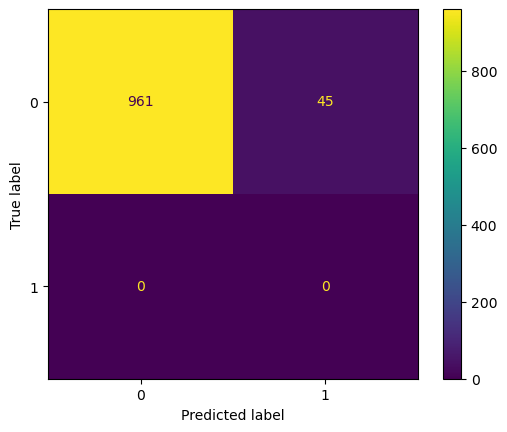

None


In [49]:
dummy_clf, y_pred_optimal_dummy,y_pred_proba_dummy, results = modele_dummy(X_train,y_train,X_test,y_test)

**5.1 La régression logistique**

Création d'un modèle de régression logistique
Entrainement du modèle sur X_train / y_train
Optimisation du seuil de classification pour maximiser l'AUC
Création d'un dictionnaire de scoring
Execution de GridSearchCV sur le modèle
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters:  {'C': 0.001, 'class_weight': {0: 2.0, 1: 2.0}, 'penalty': 'l2'}
Best accuracy:  0.8329268292682925
Best recall:  0.8329268292682925
Best cost:  81.4
Best precision score:  0.7174727521074399
Ajustement du modèle avec les paramètres optimisés
Optimisation du seuil de classification pour maximiser l'AUC
Scores du modèle après optimisation
                Modèle  Best accuracy  Best recall  Best cost  \
0  Logistic Regression           0.72         0.91        322   

   Best precision Score  True Positives  True Negatives      sampling  \
0                  0.13              41             679  oversampling   

  standardisation                                         Best param feat

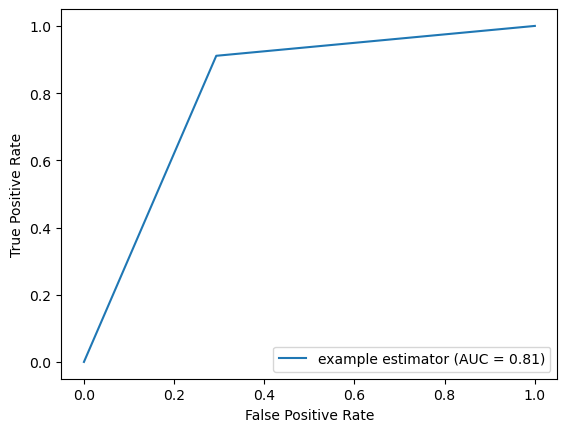

None
Affichage du rapport de classification après optimisation
              precision  recall  f1-score  support
0                  0.99    0.71      0.83   961.00
1                  0.13    0.91      0.22    45.00
accuracy           0.72    0.72      0.72     0.72
macro avg          0.56    0.81      0.52  1006.00
weighted avg       0.96    0.72      0.80  1006.00
None
Affichage de la matrice de confusion après optimisation


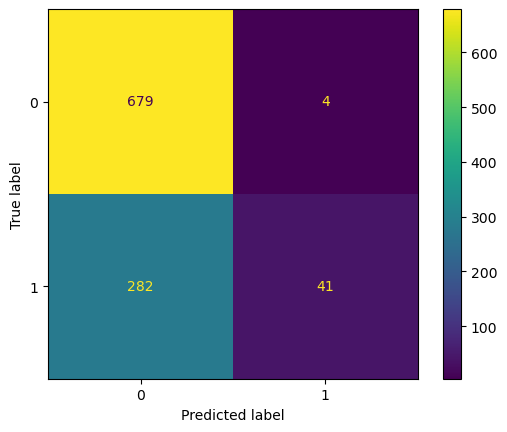

None


In [50]:
y_pred, y_proba, log_reg_model, y_pred_best, y_proba_best, best_log_reg_model, results_log_reg, df_result_log_reg = logistic_regression(X_train,y_train,X_test,y_test,x_col,mode='oversampling',standardiser='MinMaxScaler',feature='age')

**5.2 Random Forest** 

******* Création d'un modèle ********
******* Entrainement du modèle sur X_train / y_train *******
******* Optimisation du seuil de classification pour maximiser l'AUC *******
******* Création d'un dictionnaire pour optimiser les paramètres ******* 
******* Création d'un dictionnaire de scoring ******* 
******* Execution de GridSearchCV sur le modèle ******* 
Fitting 5 folds for each of 40 candidates, totalling 200 fits
******* Best parameters:  {'class_weight': 'balanced', 'max_depth': 1, 'n_estimators': 10}
******* Best accuracy: 0.85
******* Best recall: 0.85
******* Best cost: 78.00
******* Best precision score: 0.69
******* Ajustement du modèle avec les paramètres optimisés ******* 
******* Optimisation du seil de classification pour maximiser l'AUC ******* 
******* Scores du modèle après optimisation ******* 
          Modèle  Best accuracy  Best recall  Best cost  Best precision Score  \
0  Random forest           0.72         0.91        322                  0.13   

   True Po

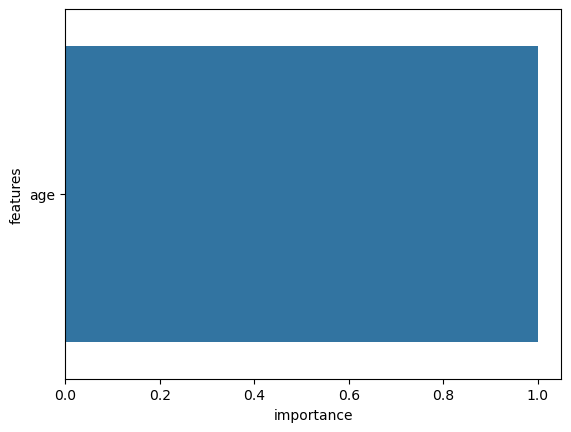

None
******* Affichage de la courbe Roc après optimisation ******* 


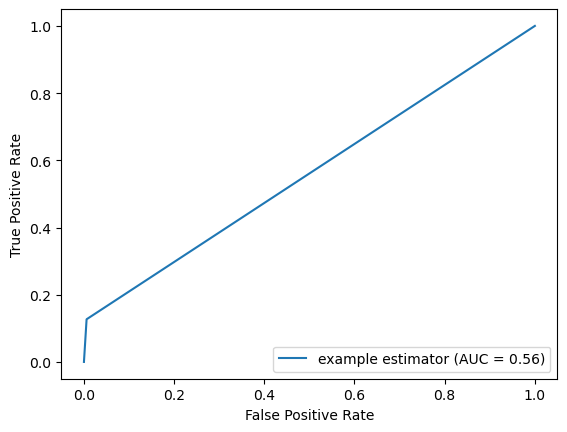

None
******* Affichage du rapport de classification après optimisation ******* 
              precision  recall  f1-score  support
0                  0.99    0.71      0.83   961.00
1                  0.13    0.91      0.22    45.00
accuracy           0.72    0.72      0.72     0.72
macro avg          0.56    0.81      0.52  1006.00
weighted avg       0.96    0.72      0.80  1006.00
None
******* Affichage de la matrice de confusion après optimisation ******* 


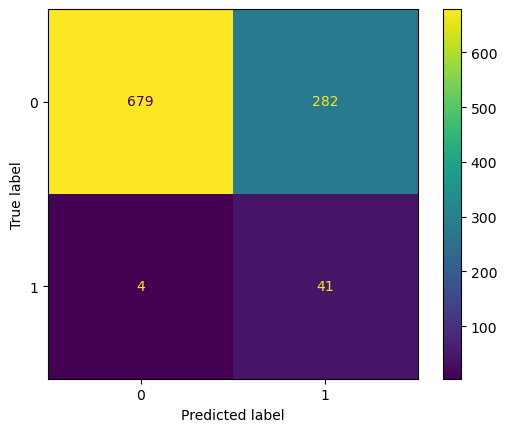

None


In [51]:
y_pred, y_proba, rf_model, y_pred_best, y_proba_best, best_rf_model,results_rf, df_result_rf = random_forest(X_train,y_train,X_test,y_test,x_col,mode='oversampling',standardiser='MinMaxScaler',feature='age')

**5.3 SVM** 

******* Création d'un modèle SVM ********
******* Entrainement du modèle sur X_train / y_train *******
******* Création d'un dictionnaire pour optimiser les paramètres ******* 
******* Création d'un dictionnaire de scoring ******* 
******* Execution de GridSearchCV sur le modèle ******* 
Fitting 5 folds for each of 27 candidates, totalling 135 fits
******* Best parameters:  {'C': 0.01, 'gamma': 1, 'kernel': 'poly'}
******* Best accuracy: 0.99
******* Best recall: 0.99
******* Best cost: 36.00
******* Best precision score: 0.56
******* Ajustement du modèle avec les paramètres optimisés ******* 
******* Scores du modèle après optimisation ******* 
  Modèle  Best accuracy  Best recall  Best cost  Best precision Score  \
0    SVM           0.29          1.0        713                  0.06   

   True Positives  True Negatives      sampling standardisation  \
0              45             248  oversampling    MinMaxScaler   

                                  Best param feature  
0  {'C': 

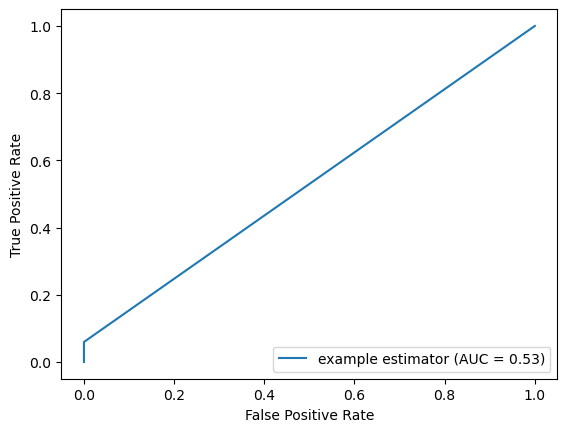

None
******* Affichage du rapport de classification après optimisation ******* 
              precision  recall  f1-score  support
0                  1.00    0.26      0.41   961.00
1                  0.06    1.00      0.11    45.00
accuracy           0.29    0.29      0.29     0.29
macro avg          0.53    0.63      0.26  1006.00
weighted avg       0.96    0.29      0.40  1006.00
None
******* Affichage de la matrice de confusion après optimisation ******* 


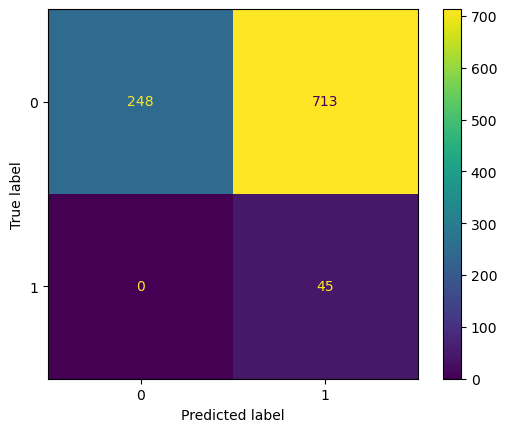

None


In [52]:
y_pred_best, y_proba_best, svm_model, best_svm_model, results, df_results_svm = svm_classifier(X_train,y_train,X_test,y_test,x_col,mode='oversampling',standardiser='MinMaxScaler',feature='age')

Avec comme variable age, le meilleur modèle est le random forest.

## 6.Evaluation des résultats

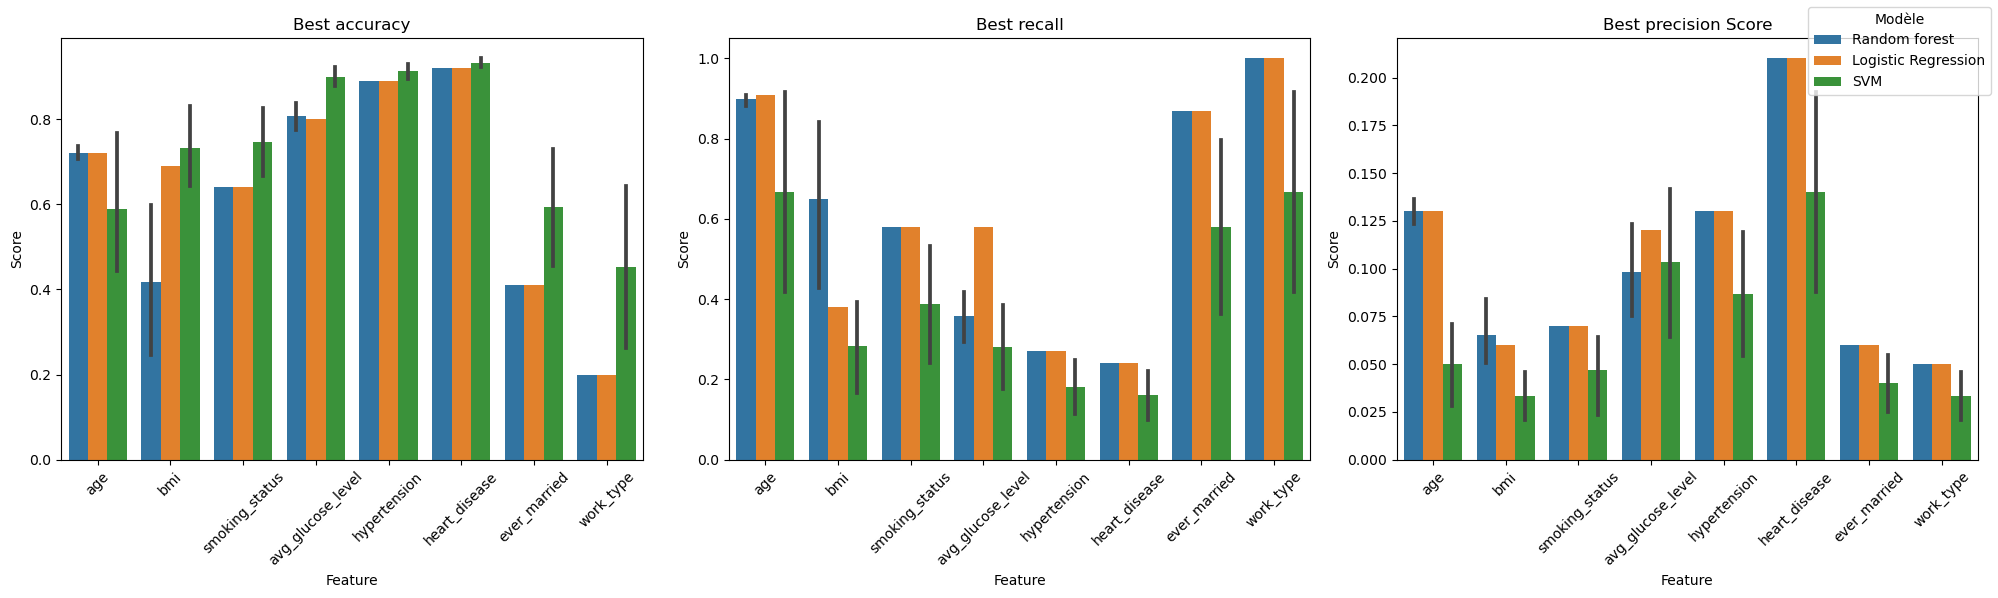

In [53]:
# Liste des métriques à afficher
metriques = ['Best accuracy', 'Best recall', 'Best precision Score']

# Nombre de graphiques par ligne
graphiques_par_ligne = 3

# Calcul du nombre de lignes
nombre_de_lignes = 1

# Création des sous-graphiques
fig, axs = plt.subplots(nombre_de_lignes, graphiques_par_ligne, figsize=(20, 6 * nombre_de_lignes))

# Parcours des métriques
for i, metrique in enumerate(metriques):
    # Restructurer les données pour cette métrique
    df_melted = df_eval.melt(id_vars=['Modèle', 'feature'], 
                             value_vars=[metrique],
                             var_name='Métrique', 
                             value_name='Score')
    
    # Tracer le graphique
    ax = axs[i]
    sns.barplot(data=df_melted, x='feature', y='Score', hue='Modèle', ax=ax)
    ax.set_title(metrique)
    ax.set_xlabel('Feature')
    ax.set_ylabel('Score')
    ax.get_legend().remove()  
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Afficher une seule légende en dehors des graphiques
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='Modèle')

plt.tight_layout()
plt.show()

## 7.Application d'un model avec plusieurs features

Ce graphique nous permet de déterminer quelles variables on un poids dans notre modèle.  
Variables retenues :  
* avg_glucose_level
* hypertension
* heart_diseases
* smoking_status

### On fait une recherche approfondie des meilleures modèles, variables, Scaler en une seule exécution, on se base des conclusions de cette expérience pour le random forest final

### Random Forest 

In [54]:
X_train, X_test, y_train, y_test, x_col = preprocessing(df_cleaned[['age','avg_glucose_level','hypertension','heart_disease','smoking_status','stroke']],standardiser=RobustScaler(),mode='undersampling',nbr_feature=6)

******* Création d'un modèle ********
******* Entrainement du modèle sur X_train / y_train *******
******* Optimisation du seuil de classification pour maximiser l'AUC *******
******* Création d'un dictionnaire pour optimiser les paramètres ******* 
******* Création d'un dictionnaire de scoring ******* 
******* Execution de GridSearchCV sur le modèle ******* 
Fitting 5 folds for each of 40 candidates, totalling 200 fits
******* Best parameters:  {'class_weight': 'balanced', 'max_depth': 1, 'n_estimators': 50}
******* Best accuracy: 0.86
******* Best recall: 0.86
******* Best cost: 70.40
******* Best precision score: 0.71
******* Ajustement du modèle avec les paramètres optimisés ******* 
******* Optimisation du seil de classification pour maximiser l'AUC ******* 
******* Scores du modèle après optimisation ******* 
          Modèle  Best accuracy  Best recall  Best cost  Best precision Score  \
0  Random forest           0.73         0.96        289                  0.14   

   True Po

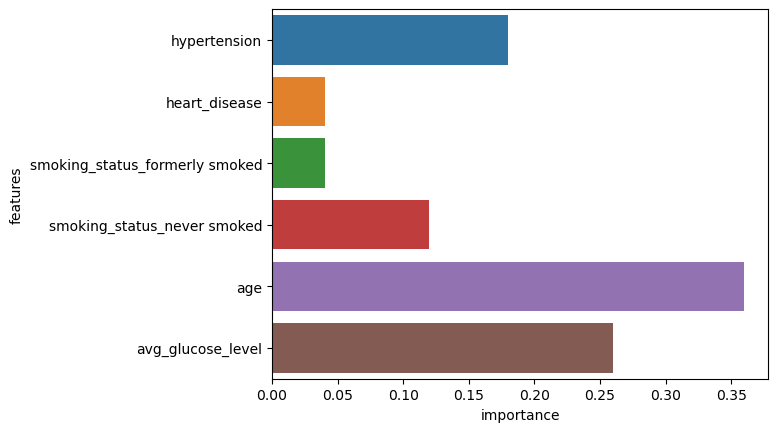

None
******* Affichage de la courbe Roc après optimisation ******* 


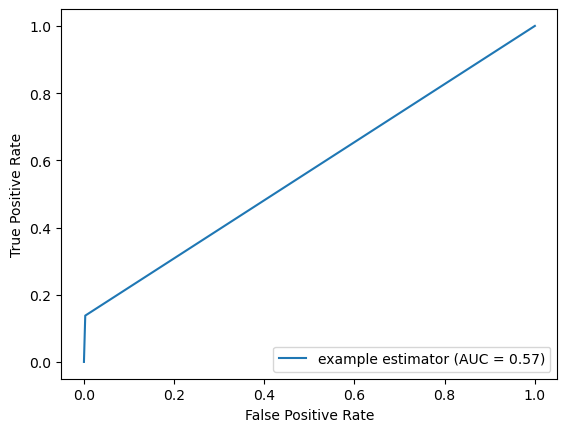

None
******* Affichage du rapport de classification après optimisation ******* 
              precision  recall  f1-score  support
0                  1.00    0.72      0.84   961.00
1                  0.14    0.96      0.24    45.00
accuracy           0.73    0.73      0.73     0.73
macro avg          0.57    0.84      0.54  1006.00
weighted avg       0.96    0.73      0.81  1006.00
None
******* Affichage de la matrice de confusion après optimisation ******* 


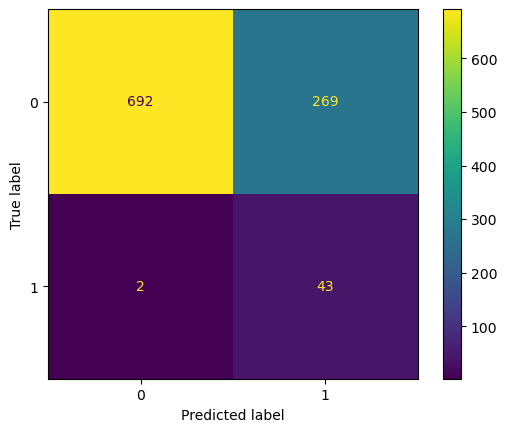

None


In [55]:
y_pred, y_proba, rf_model, y_pred_best, y_proba_best, best_rf_model,results_rf, last_result = random_forest(X_train,y_train,X_test,y_test,x_col,mode='undersampling',standardiser='Robustscaler',feature='age +3')

Il est important de vérifier si nos variables explicatives ne sont pas dans un cas de multicolinéarité.  
Pour cela, je calcule le VIF (Variance Inflation Factor) qui indique multicolinéarité lorsque le score dépasse 10.

In [56]:
vif_data = pd.DataFrame()
vif_data["feature"] = list(X_train)
vif_data["VIF"] = [variance_inflation_factor(X_train, i)
                          for i in range(len(X_train.columns))]

print('VIF (facteur d\'inflation de la variance)')
print(vif_data)

VIF (facteur d'inflation de la variance)
                          feature       VIF
0                    hypertension  1.277585
1                   heart_disease  1.214403
2  smoking_status_formerly smoked  1.145788
3     smoking_status_never smoked  1.355920
4                             age  1.291732
5               avg_glucose_level  1.262183


## Lime 

In [58]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                 mode='classification',
                                 class_names=['Pas AVC', 'AVC'],
                                 feature_names=list(X_train.columns),
                                 random_state=42)


In [60]:
best_rf_explanation = explainer.explain_instance(X_test.values[97],
                                               best_rf_model.predict_proba,
                                               num_features = 5
                                               )
best_rf_explanation.show_in_notebook(show_table=True)

On obtient des résultats déjà assez satisfaisants en n'utilisant que la feature age sur les models de régression linéaire et random forest. Le recall étant élevé sans pour autant trop perdre en accuracy comme c'est le cas avec le SVM qui lui excelle en recall mais réalise beaucoup trop de prédiction de risques d'AVC, ce qui dégrade fortement son accuracy.

On peut bien entendu espérer de meilleurs résultats en ajoutant de nouvelles variables à l'entraînement du model. 

## **8 Conclusion sur la modélisation la plus efficace pour la prévention des attaques cérébrales.**


Le random forest utilisé avec les variables sélectionnées obtient ces résultats:
* Accuracy : 0.86
* Recall : 0.86
* True positives : 43
* True negatives :  692

Le modèle contenant plusieurs features permet de détecter plus de patient atteint d'avc mais il prédit également légèrement plus de faux positif que le modèle avec seulement la variable 'age'.
